In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/'Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


# **<h1>Deep RL lecture 2.</h1>**

# **<h2>NN as Function approximators  vs Probability Distributions</h2>**

This is one of the core concepts in cs224r.
There are 2 ways to represent a NN.

<h4>Function approximator</h4>
<ul>
<li>deterministic policy is implemented as a function approximator</li>
<li>a deterministic policy outputs a non-random action for a given state; $a=\pi(s)$ </li>
<li>Lecture 2 mentions using supervised learning which is using a NN through a process of optimizing to reduce the squared error via iterations and back propagation. This is the same as function approximation. </li>
<li>approximating a function $y=f(x)$</li>
<li>NN outputs a MSE as proof it is working. </li>
</ul>

<h4>Probability distribution</h4>
<ul>
<li>A probability distribution model is represented by a conditional probability $p(y|x)$ or $action = p(s)$.</li>
<li>stochastic policy</li>
<li>If the distribution has a known representation then output in that form. For example a gaussian can be represented by a mean and variance. A multinomial by a vector the length of number of classes with a probability for each class and they sum to 1. Following the probability axioms. [1/6,1/6,1/6,1/6,1/6,1/6] for a single dice. Always fallback to dice or a known item and rederive up from there. </li>
<li>NN outputs a mean and variance for gaussian distribution as proof it is working if the distribution is known.</li>
<li>The PR Distribution consists of a model which generates p(y|x) which means there is an output value y given x. </li>
<li>To give someone your PR distribution give them the weights and the archicture of the layers. </li>
<li>This is what a vLLM is; it outputs p(y|x) for a model. But you have to port the LLM to a recognizable format like HF.  </li>
</ul>

   
<h4>Pytorch DL Fn Approximator</h4>
<ul>
<li>A multilayer perceptron consists of multiple layers of linear layers, $h=Wx+b$ and a nonlinear activation function a tanh or relu,$activation=\sigma(h)$ </li>
<li>Multiple linear layers + nonlinear activation use piecewise linear approximation to match nonlinear fns. </li>
<li>Adding noise to the input data is not the same as a stochastic model. Noise is stochastic but the model is not.</li>
<b><li>pytorch notes: format data as (B,T,C) where (1024) should be T and unsqueeze(-1) to (1024,1). The 1024 is the shape of sin(x)+noise</li><\b>
</ul>

```
import torch
import torch.nn as nn
import torch.optim as optim

# Data: y = sin(x) + noise
def make_data(n=1024):
    x = torch.linspace(-3.14, 3.14, n).unsqueeze(-1)  # (n, 1)
    y = torch.sin(x) + 0.1 * torch.randn_like(x)
    return x, y


class MLPRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.net(x)  # deterministic output y_hat

x, y = make_data()
model = MLPRegressor()
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for step in range(400):
  opt.zero_grad()
  y_hat = model(x)
  loss = loss_fn(y_hat, y)
  loss.backward()
  if step%100==0:
    print("%.2f" % round(loss.item(),2))
  opt.step()

print("Final MSE:", loss.item())

```
</b>

<h4>Pytorch Probability Distribution</h4>
<ul>
<li>One of the issues with L2 loss in the continuous case is the lowest loss gives an improbable mean. If there are 2 peaks representing 2 means at x1 and x2 then a L2 loss can give a loss in the middle between x1 and x2. This is an improbable event because it is so far away from either mean. This is a multimodal distribution. </li>
</ul>


```
#NN as a gaussian distribution model.

import torch
import torch.nn as nn
import torch.optim as optim

def make_data(n=1024):
    x = torch.linspace(-3.14, 3.14, n).unsqueeze(-1)
    y = torch.sin(x) + 0.3 * torch.randn_like(x)
    return x, y

class GaussianRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
        )
        self.mean_head = nn.Linear(64, 1)
        self.logvar_head = nn.Linear(64, 1)  # log variance

    def forward(self, x):
        h = self.net(x)
        mean = self.mean_head(h)
        logvar = self.logvar_head(h)
        return mean, logvar

def gaussian_nll(y, mean, logvar):
    # Negative log-likelihood of y under N(mean, exp(logvar))
    # 0.5*( (y-mean)^2 / var + logvar + log(2π) )
    var = torch.exp(logvar)
    return 0.5 * ((y - mean)**2 / var + logvar + torch.log(torch.tensor(2.0 * torch.pi))).mean()

x, y = make_data()
model = GaussianRegressor()
opt = optim.Adam(model.parameters(), lr=1e-3)

for step in range(2000):
    opt.zero_grad()
    mean, logvar = model(x)
    loss = gaussian_nll(y, mean, logvar)
    loss.backward()
    opt.step()

print("Final NLL:", loss.item())

# Sampling from the learned distribution at a given x0:
x0 = torch.tensor([[0.5]])
mean0, logvar0 = model(x0)
std0 = torch.exp(0.5 * logvar0)
samples = mean0 + std0 * torch.randn(10, 1)
print("Mean at 0.5:", mean0.item(), "Std:", std0.item())
print("Samples:", samples.squeeze().tolist())

Final NLL: 0.2034371793270111
Mean at 0.5: 0.4156067967414856 Std: 0.30745232105255127
Samples: [0.2682528495788574, 0.26575446128845215, 0.23795229196548462, 0.10733562707901001, 0.5020239353179932, 0.3697490096092224, 0.36694231629371643, 0.16986136138439178, 0.714669406414032, -0.23383790254592896]

```

<h4>
Possible confusion: instructor mentions  L2 loss, what is the difference between using L2 vs MSE? When to use and why?</h4>

<ul>
<li>MSE: $\sum_i (y_i - \hat{y_i})^2$ </li>
<li>L2: $\frac{1}{N}\sum_i (y_i - \hat{y_i})^2$</li>
<li>RMSE = $\sqrt{MSE}$</li>
</ul>

<p>L2 is N times smaller but the L2 gradient is N times larger. This is a common point of confusion. MSE is more stable WRT batch size. </p>

<ul>
<li>$\frac{\partial L_{L2}}{\partial{\hat{y_i}}}=2(y_i-\hat{y_i})d(\hat{y_i})=-2(y_i-\hat{y_i})$</li>
<li>$\frac{\partial L_{MSE}}{\partial{\hat{y_i}}}=\frac{-2}{N}(y_i-\hat{y_i})$</li>
<li>$\frac{\partial L_{L2}}{\partial{\hat{y_i}}}=N*\frac{\partial L_{MSE}}{\partial{\hat{y_i}}}$</li>
<li>Can see the MSE gradient varies with the batch size N. L2 gradients explode with larger batch size. Most NN use MSE vs L2 if there is a choice</li>
</ul>

<h1>Probability Distributions Multinomial</h1>

<ul>
<li>This is what LLMs are</li>
<li>The ouput of the probability distribution model are a vector of probabilities which sum to 1 and each entry in the vector is an action. </li>
<li>The parameters of the model are the weights and biases in the layers and a description of the layers of the model specifying a forward pass for the parameters.</li>
<li>In the case of LLMs, the input to the probability distrubiton is a set of query tokens, the output is a set of output tokens with probabilities which sum to 1.  </li>
<li>Do you return the highest probability from and re-enter that into the input which is autoregressive. Each token can lead to a different trajectory or rollout</li>
</ul>



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# --- 1. Data Generation (The "Expert") ---
# Discrete actions: 0, 1, or 2
NUM_ACTIONS = 3

class ExpertDataset(Dataset):
    def __init__(self, num_samples=1000):
        # State (s): A single scalar input (e.g., a feature from the environment)
        # Action (a): An integer representing the discrete action taken (0, 1, or 2)

        # 1. Generate random states in the range [-5, 5]
        self.states = np.random.uniform(-5.0, 5.0, num_samples).astype(np.float32)

        # 2. Define the expert's deterministic policy for simplicity:
        # Action 0 if s < -1
        # Action 1 if -1 <= s <= 1
        # Action 2 if s > 1
        actions = np.zeros(num_samples, dtype=np.int64)
        actions[np.where((self.states >= -1.0) & (self.states <= 1.0))] = 1
        actions[np.where(self.states > 1.0)] = 2
        self.actions = actions

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        # PyTorch requires tensors
        state = torch.tensor(self.states[idx]).unsqueeze(0) # Input size (1,)
        # Note: Actions are NOT one-hot encoded here, CrossEntropyLoss handles the integer
        action = torch.tensor(self.actions[idx])            # Target size (1,)
        return state, action

# --- 2. Model Definition (The Stochastic Policy Network) ---
class StochasticPolicyNetwork(nn.Module):
    def __init__(self, input_size, num_actions):
        super(StochasticPolicyNetwork, self).__init__()
        # The network outputs the un-normalized scores (logits) for each action
        self.net = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            # Final layer outputs a vector of size NUM_ACTIONS
            nn.Linear(64, num_actions)
        )

    def forward(self, x):
        # The output are the LOGITS (un-normalized scores)
        # CrossEntropyLoss expects logits, not probabilities
        logits = self.net(x)
        return logits

    def get_action_probabilities(self, x):
        # To get the probabilities that sum to 1, we apply the Softmax function
        logits = self.forward(x)
        probabilities = torch.softmax(logits, dim=-1) # Apply softmax across the action dimension
        return probabilities

# --- 3. Training Loop (Behavioral Cloning/MLE) ---
def train_bc_multinomial(model, dataloader, num_epochs=50, lr=1e-3, weight_decay=1e-5):
    # Loss Function: Cross-Entropy Loss (NLL for Categorical Distribution/MLE)
    # This loss includes the Softmax computation internally on the logits
    criterion = nn.CrossEntropyLoss()

    # Optimizer: Adam, using L2 regularization via weight_decay (MAP objective)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(f"Starting training on {device}...")

    for epoch in range(num_epochs):
        total_loss = 0
        for states, expert_actions in dataloader:
            states = states.to(device)
            # Expert actions must be long integers for CrossEntropyLoss
            expert_actions = expert_actions.to(device).long()

            optimizer.zero_grad()

            # Forward pass: Policy outputs logits
            logits = model(states)

            # Calculate the loss: compares logits to the true integer action
            loss = criterion(logits, expert_actions)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    print("Training finished.")
    return model

# --- Execution ---
if __name__ == "__main__":
    # Parameters
    INPUT_SIZE = 1

    # 1. Prepare Data
    expert_data = ExpertDataset(num_samples=10000)
    data_loader = DataLoader(expert_data, batch_size=64, shuffle=True)

    # 2. Initialize Model
    policy_model = StochasticPolicyNetwork(INPUT_SIZE, NUM_ACTIONS)

    # 3. Train Model
    trained_policy = train_bc_multinomial(policy_model, data_loader)

    # --- 4. Evaluation ---
    print("\nEvaluating Stochastic Policy...")

    # Test states chosen near the decision boundaries
    test_states = torch.tensor([[-2.0], [-1.0], [0.0], [1.0], [2.0]], dtype=torch.float32)

    trained_policy.eval()
    with torch.no_grad():
        # Get the final probability vector for each test state
        probs = trained_policy.get_action_probabilities(test_states).cpu().numpy()

    print("\n| State (s) | P(Action 0) | P(Action 1) | P(Action 2) | Sum | Expert Action |")
    print("|-----------|-------------|-------------|-------------|-----|---------------|")

    for i in range(len(test_states)):
        s = test_states[i].item()
        p0, p1, p2 = probs[i]
        p_sum = p0 + p1 + p2

        # Determine the expected expert action based on the data logic
        expert_a = 0
        if -1.0 <= s <= 1.0:
            expert_a = 1
        elif s > 1.0:
            expert_a = 2

        print(f"| {s:.1f}       | {p0:.4f}      | {p1:.4f}      | {p2:.4f}      | {p_sum:.0f} | {expert_a}             |")

    print("\n--- Summary ---")
    print("The policy outputs a probability vector that sums to 1.0 for each state.")
    print("Near the boundaries (-1.0 and 1.0), the policy shows uncertainty (probabilities are not 0 or 1), reflecting its stochastic nature.")

Starting training on cpu...
Epoch 10/50, Loss: 0.0103
Epoch 20/50, Loss: 0.0073
Epoch 30/50, Loss: 0.0054
Epoch 40/50, Loss: 0.0052
Epoch 50/50, Loss: 0.0047
Training finished.

Evaluating Stochastic Policy...

| State (s) | P(Action 0) | P(Action 1) | P(Action 2) | Sum | Expert Action |
|-----------|-------------|-------------|-------------|-----|---------------|
| -2.0       | 1.0000      | 0.0000      | 0.0000      | 1 | 0             |
| -1.0       | 0.8249      | 0.1751      | 0.0000      | 1 | 1             |
| 0.0       | 0.0000      | 1.0000      | 0.0000      | 1 | 1             |
| 1.0       | 0.0000      | 0.6808      | 0.3192      | 1 | 1             |
| 2.0       | 0.0000      | 0.0000      | 1.0000      | 1 | 2             |

--- Summary ---
The policy outputs a probability vector that sums to 1.0 for each state.
Near the boundaries (-1.0 and 1.0), the policy shows uncertainty (probabilities are not 0 or 1), reflecting its stochastic nature.


# **Imitation Learning**
The concept is to imitate an expert, much in way a smaller model is distiled from a bigger model with more parameters. The funcamental problem is covariate shift where if there is an undersampled region then this error propagates and grows.

Behavior cloning is the simplest IL algorithm.  Train a policy $\pi_{\theta}$ to imitate an expert. $\theta_{BC}$ becomes the parameters of the distribution we are going to find through supervised learning from an expert.


$$\theta_{BC} = \operatorname*{argmax}_{\theta} \mathbb{E}_{(s, a) \sim D} [\log \pi_{\theta}(a \mid s)]$$

Minimize the NLL, for discrete data use Cross Entropy as NLL;  for continuous data, use MSE


<h5>Lecture 2, Behavioral cloning version 0. $model=p(y|x; \theta)$. </h5>

Behavioral Cloning Version 0

find the policy parameters $\theta$ for policy $\pi_{\theta}$ from demonstarations $\mathbb{D}={s_i,a_i}$


For deterministic policy use supervised regression to mimic the expert.

<ol>
<li>Given Demonstrations collected by expert $\mathbb{D} = {s_1,a_1,s_2,a_2,...,s_n,a_n}$</li>

<li>Train $\pi_{\theta}$ predict an action $\hat{a}$, we want the predicted action to be as close to $a_n$ from the expert demonstrations in 1. </li>

<li>If the policy is a NN, do a forward pass to get the predicted actions, compute the loss and Back Prop into params of NN, iteratively w optimizer</li>

<li>following step above we want to minimize the difference between the predicted action a-hat and the action in the demonstration dataset. $\operatorname*{min}_{\theta} \frac{1}{\mathbb{|D|}} \sum_{s_n, a_n} ||a - \hat{a}||^2$ where $\hat{a} =\pi_{theta}(s)$ and the minimzation is performed over ALL the states and actions $a_n, s_n$
</li>
<li>Deploy learned poicy $\pi_{\theta}$
</li>
<ol>

<h4>11:21 multimodal collapse problem</h4>
<ul>
If there are 2 steering angles one at mean x1 and another at mean x2 and if x1 and x2 are 10 apart and the squared loss picks the lowest loss to be equidistant between x1 and x2 then the lowest loss has a low probabiity and is incorrect in almost all the cases.
<li>GMMs, gaussian mixture models</li>
<li>GAIL, NOT IN LECTURE but relevant</li>
</ul>



# **Mode Collapse Gaussian, Multinomial**

True mean of the multimodal expert actions (the 'trough'): 10.00
Starting training on cpu...
Epoch 20/100, Loss: 25.360407
Epoch 40/100, Loss: 25.363625
Epoch 60/100, Loss: 25.385040
Epoch 80/100, Loss: 25.364577
Epoch 100/100, Loss: 25.403072
Training finished.

--- Multimodal Collapse Analysis ---
Mode 1 Mean: 5.00
Mode 2 Mean: 15.00
-----------------------------------
Policy's Predicted Action (Output): 10.0525

**RESULT: MULTIMODAL COLLAPSE CONFIRMED.**
The policy converged to the arithmetic mean (trough) between the two modes.


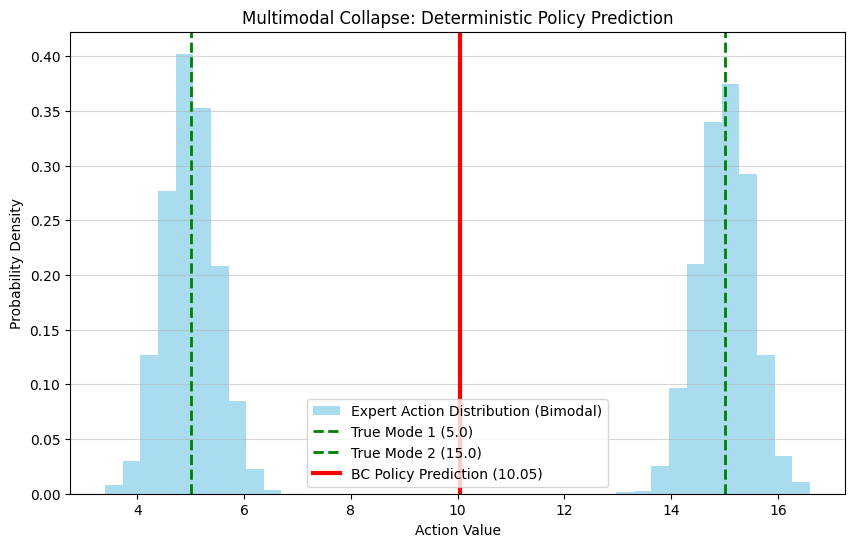

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Data Generation (The Bimodal Expert) ---
class BimodalExpertDataset(Dataset):
    def __init__(self, num_samples=4000):
        # State (s): A single scalar input. Constant state to simplify the collapse demonstration.
        self.states = np.ones(num_samples, dtype=np.float32)

        MODE_1_MEAN = 5.0
        MODE_2_MEAN = 15.0
        STD_DEV = 0.5

        N = num_samples // 2

        # Generate data for two widely separated modes
        actions_m1 = np.random.normal(MODE_1_MEAN, STD_DEV, N)
        actions_m2 = np.random.normal(MODE_2_MEAN, STD_DEV, N)

        self.actions = np.concatenate([actions_m1, actions_m2]).astype(np.float32)

        # Shuffle and store for easy plotting later
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        self.states = self.states[indices]
        self.actions = self.actions[indices]

        # Store for analysis
        self.mode_1_mean = MODE_1_MEAN
        self.mode_2_mean = MODE_2_MEAN

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        state = torch.tensor(self.states[idx]).unsqueeze(0)
        action = torch.tensor(self.actions[idx]).unsqueeze(0)
        return state, action

# --- 2. Model Definition (Deterministic MLP) ---
class DeterministicPolicy(nn.Module):
    def __init__(self, input_size=1, output_size=1):
        super(DeterministicPolicy, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, output_size) # Outputs a single predicted action (the mean)
        )

    def forward(self, x):
        return self.net(x)

# --- 3. Training Loop ---
def train_bc(model, dataloader, num_epochs=100, lr=1e-3):
    # MSE is the NLL for the unimodal Gaussian assumption
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(f"Starting training on {device}...")

    for epoch in range(num_epochs):
        total_loss = 0
        for states, expert_actions in dataloader:
            states, expert_actions = states.to(device), expert_actions.to(device)

            optimizer.zero_grad()

            predicted_actions = model(states)
            loss = criterion(predicted_actions, expert_actions)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader):.6f}")

    print("Training finished.")
    return model

# --- 4. Execution, Analysis, and Visualization ---
if __name__ == "__main__":

    # 1. Prepare Data
    expert_data = BimodalExpertDataset(num_samples=4000)
    data_loader = DataLoader(expert_data, batch_size=64, shuffle=True)

    true_mean = expert_data.actions.mean()
    print(f"True mean of the multimodal expert actions (the 'trough'): {true_mean:.2f}")

    # 2. Initialize and Train Model
    policy_model = DeterministicPolicy()
    trained_policy = train_bc(policy_model, data_loader)

    # 3. Evaluate Collapse
    test_state = torch.tensor([[1.0]], dtype=torch.float32)
    trained_policy.eval()
    with torch.no_grad():
        predicted_action = trained_policy(test_state).item()

    print("\n--- Multimodal Collapse Analysis ---")
    print(f"Mode 1 Mean: {expert_data.mode_1_mean:.2f}")
    print(f"Mode 2 Mean: {expert_data.mode_2_mean:.2f}")
    print("-" * 35)
    print(f"Policy's Predicted Action (Output): {predicted_action:.4f}")

    if abs(predicted_action - true_mean) < 0.5:
        print("\n**RESULT: MULTIMODAL COLLAPSE CONFIRMED.**")
        print("The policy converged to the arithmetic mean (trough) between the two modes.")

    # 4. Visualization (Colab Compatible)

    plt.figure(figsize=(10, 6))

    # Plot the histogram of the expert's actions
    plt.hist(expert_data.actions, bins=40, density=True, color='skyblue', alpha=0.7,
             label='Expert Action Distribution (Bimodal)')

    # Plot the true means (modes)
    plt.axvline(expert_data.mode_1_mean, color='green', linestyle='--', linewidth=2,
                label='True Mode 1 (5.0)')
    plt.axvline(expert_data.mode_2_mean, color='green', linestyle='--', linewidth=2,
                label='True Mode 2 (15.0)')

    # Plot the policy's prediction (the collapse point)
    plt.axvline(predicted_action, color='red', linestyle='-', linewidth=3,
                label=f'BC Policy Prediction ({predicted_action:.2f})')

    plt.title("Multimodal Collapse: Deterministic Policy Prediction")
    plt.xlabel("Action Value")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(axis='y', alpha=0.5)
    plt.show()

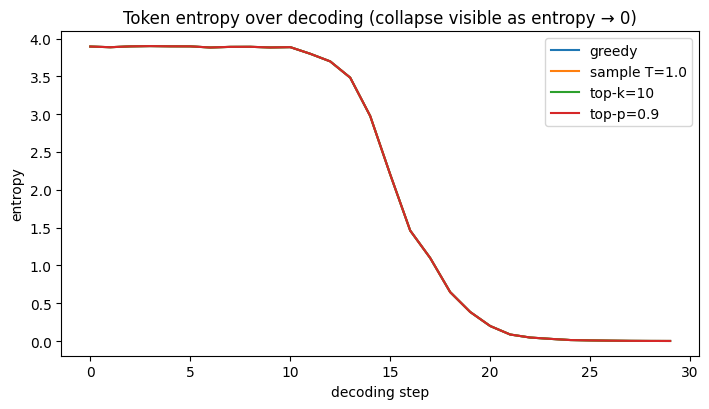

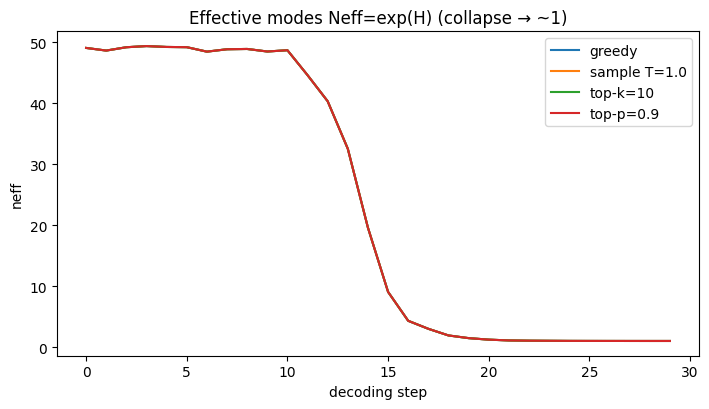

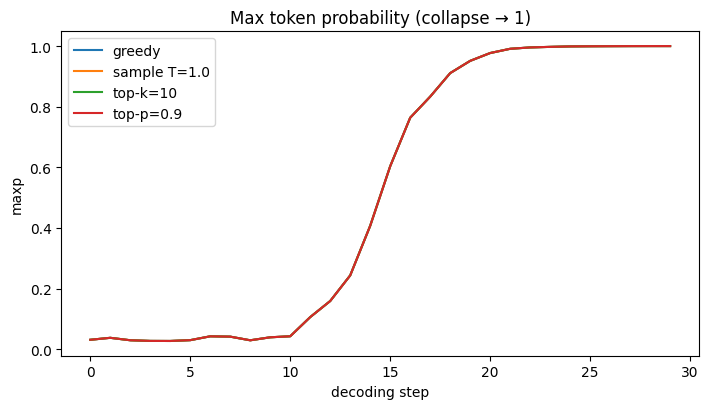

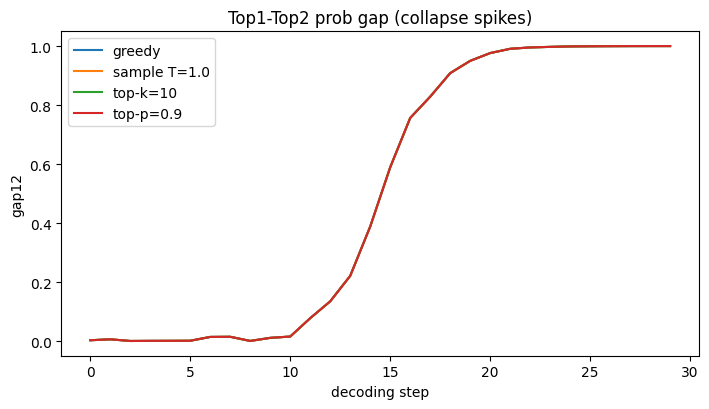

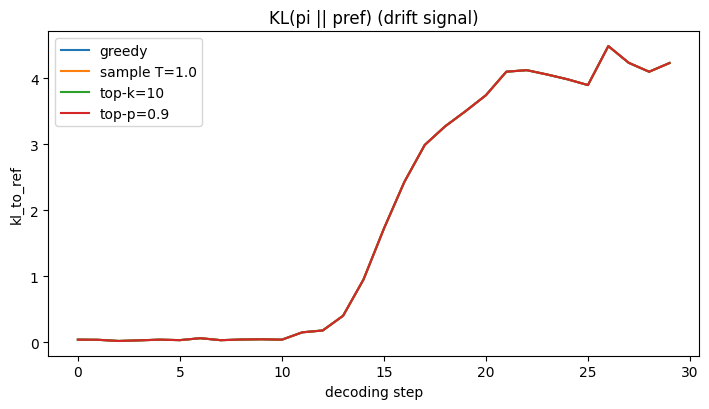

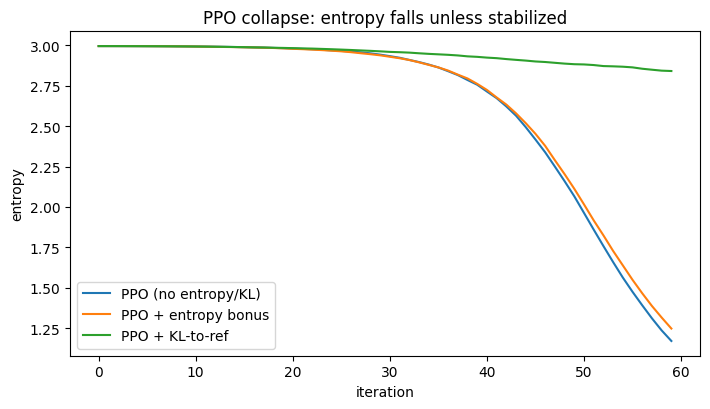

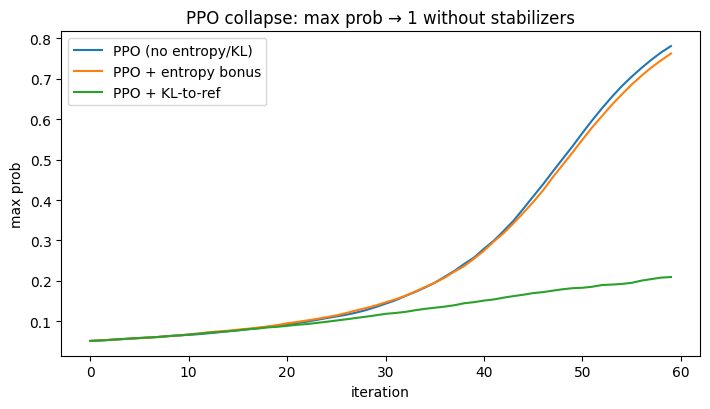

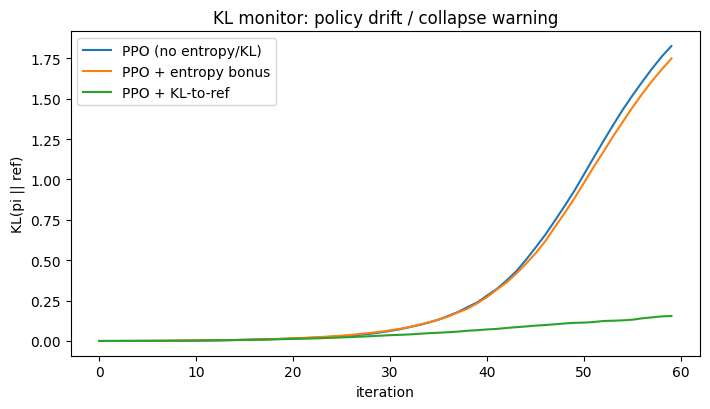


Math intuition:
Softmax with temperature:   p_i(T) ∝ exp(z_i / T)
Log-odds scale:             log(p_i/p_j) = (z_i - z_j)/T  (so lower T magnifies gaps)

Top-k: sets all but k logits to -∞ => p_i=0 outside top-k => prevents extremely peaked
      dominance from rare far-tail tokens; also increases entropy floor within top-k.

Top-p (nucleus): keeps smallest set S with sum_{i in S} p_i ≥ p; renormalize over S.
      If one token tries to dominate too hard, S can still include others unless p is tiny.

Both enforce a truncated support, which bounds how small probabilities can get among kept tokens.


In [ ]:
import math
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

# ============================================================
# 0) Collapse metrics for a categorical distribution
# ============================================================

def cat_metrics_from_logits(logits: torch.Tensor, ref_logits: torch.Tensor | None = None, dim=-1):
    """
    logits: [..., V]
    ref_logits: [..., V] (optional) for KL(pi || pref)
    Returns dict of tensors broadcast over leading dims.
    """
    logp = F.log_softmax(logits, dim=dim)
    p    = logp.exp()

    # Entropy H = -sum p log p
    H = -(p * logp).sum(dim=dim)

    # Effective number of modes Neff = exp(H)fdg
    Neff = H.exp()

    # Max probability
    maxp = p.max(dim=dim).values

    # Top1-top2 gap (a practical collapse detector)
    top2 = p.topk(2, dim=dim).values
    gap12 = top2[..., 0] - top2[..., 1]

    out = dict(entropy=H, neff=Neff, maxp=maxp, gap12=gap12)

    if ref_logits is not None:
        # KL(pi || pref) = sum p (log p - log pref)
        ref_logp = F.log_softmax(ref_logits, dim=dim)
        KL = (p * (logp - ref_logp)).sum(dim=dim)
        out["kl_to_ref"] = KL

    return out

# ============================================================
# 1) Decoding simulator + entropy-collapse plots
# ============================================================

def top_k_filter(logits: torch.Tensor, k: int):
    # keep only top-k logits, set others to -inf
    v, _ = torch.topk(logits, k)
    thresh = v[..., -1, None]
    return torch.where(logits >= thresh, logits, torch.full_like(logits, float("-inf")))

def top_p_filter(logits: torch.Tensor, p: float):
    # nucleus filtering: keep smallest set whose cumulative prob >= p
    # standard implementation uses sorted probs
    sorted_logits, sorted_idx = torch.sort(logits, descending=True, dim=-1)
    sorted_probs = F.softmax(sorted_logits, dim=-1)
    cum = torch.cumsum(sorted_probs, dim=-1)

    keep = cum <= p
    # ensure at least one token kept
    keep[..., 0] = True

    filtered = torch.full_like(logits, float("-inf"))
    filtered.scatter_(-1, sorted_idx, torch.where(keep, sorted_logits, torch.full_like(sorted_logits, float("-inf"))))
    return filtered

def sample_step(logits, temperature=1.0, topk=None, topp=None):
    z = logits / temperature
    if topk is not None:
        z = top_k_filter(z, topk)
    if topp is not None:
        z = top_p_filter(z, topp)
    probs = F.softmax(z, dim=-1)
    idx = torch.multinomial(probs, 1).squeeze(-1)
    return idx, probs, z

def run_decode(logits_by_step, mode, temperature=1.0, topk=None, topp=None, ref_logits_by_step=None):
    """
    logits_by_step: [T, V]
    mode: "greedy" or "sample"
    Returns dict logs: tokens, entropy, neff, maxp, gap12, (optional) kl_to_ref
    """
    T, V = logits_by_step.shape
    toks = []
    logs = {k: [] for k in ["entropy", "neff", "maxp", "gap12", "kl_to_ref"]}

    for t in range(T):
        logits = logits_by_step[t]
        ref_logits = ref_logits_by_step[t] if ref_logits_by_step is not None else None

        if mode == "greedy":
            # temperature/topk/topp irrelevant for greedy unless you filter logits first (we don't here)
            probs = F.softmax(logits, dim=-1)
            idx = int(torch.argmax(probs).item())
        else:
            idx, probs, _ = sample_step(logits, temperature=temperature, topk=topk, topp=topp)
            idx = int(idx.item())

        toks.append(idx)

        m = cat_metrics_from_logits(logits, ref_logits)
        for key in ["entropy", "neff", "maxp", "gap12"]:
            logs[key].append(float(m[key].item()))
        if "kl_to_ref" in m:
            logs["kl_to_ref"].append(float(m["kl_to_ref"].item()))
        else:
            logs["kl_to_ref"].append(np.nan)

    logs["tokens"] = toks
    return logs

# Create a toy "LM logits over time" where entropy collapses mid-way:
# step 0-3: high entropy; step 4-6: one token becomes dominant; step 7-9: near-deterministic
V = 50
T = 30
base = torch.zeros(T, V)

# start high-entropy: small random noise
base[:10] = 0.2 * torch.randn(10, V)

# gradually increase one token's logit => collapse
collapse_token = 7
for t in range(10, T):
    base[t] = 0.2 * torch.randn(V)
    base[t, collapse_token] += (t - 9) * 0.7  # ramp up dominance

# reference logits: "healthy" model that stays higher-entropy
ref = 0.2 * torch.randn(T, V)

# Run 4 decoding regimes
logs_greedy = run_decode(base, mode="greedy", ref_logits_by_step=ref)
logs_temp   = run_decode(base, mode="sample", temperature=1.0, ref_logits_by_step=ref)
logs_topk   = run_decode(base, mode="sample", temperature=1.0, topk=10, ref_logits_by_step=ref)
logs_topp   = run_decode(base, mode="sample", temperature=1.0, topp=0.9, ref_logits_by_step=ref)

def plot_metric(logs_list, labels, metric, title):
    plt.figure(figsize=(7.2, 4.2))
    for logs, lab in zip(logs_list, labels):
        plt.plot(logs[metric], label=lab)
    plt.xlabel("decoding step")
    plt.ylabel(metric)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

labels = ["greedy", "sample T=1.0", "top-k=10", "top-p=0.9"]
plot_metric([logs_greedy, logs_temp, logs_topk, logs_topp], labels, "entropy",
            "Token entropy over decoding (collapse visible as entropy → 0)")
plot_metric([logs_greedy, logs_temp, logs_topk, logs_topp], labels, "neff",
            "Effective modes Neff=exp(H) (collapse → ~1)")
plot_metric([logs_greedy, logs_temp, logs_topk, logs_topp], labels, "maxp",
            "Max token probability (collapse → 1)")
plot_metric([logs_greedy, logs_temp, logs_topk, logs_topp], labels, "gap12",
            "Top1-Top2 prob gap (collapse spikes)")
plot_metric([logs_greedy, logs_temp, logs_topk, logs_topp], labels, "kl_to_ref",
            "KL(pi || pref) (drift signal)")

# ============================================================
# 2) PPO clip failure modes for a categorical policy
# ============================================================

# We'll show a simple 1-state categorical policy over V actions.
# PPO update uses ratio clipping, but repeated updates with consistently positive advantage for one action
# can still drive collapse unless you add entropy bonus or KL-to-ref.

def ppo_update_logits(
    logits,               # [V] trainable "policy logits"
    actions,              # [B] sampled actions from old policy
    adv,                  # [B] advantages
    old_logp,             # [B] log pi_old(a)
    clip_eps=0.2,
    lr=0.1,
    ent_coef=0.0,         # add entropy bonus to prevent collapse
    ref_logits=None,      # optional KL-to-ref penalty
    kl_beta=0.0
):
    logits = logits.clone().requires_grad_(True)
    logp_all = F.log_softmax(logits, dim=-1)
    logp = logp_all[actions]

    ratio = torch.exp(logp - old_logp)
    unclipped = ratio * adv
    clipped = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps) * adv
    ppo_obj = torch.min(unclipped, clipped).mean()

    # entropy bonus (maximize entropy => add +H; for loss we subtract)
    p = logp_all.exp()
    H = -(p * logp_all).sum()
    obj = ppo_obj + ent_coef * H

    # KL-to-ref penalty: subtract beta * KL(pi || pref)
    if ref_logits is not None and kl_beta > 0:
        ref_logp_all = F.log_softmax(ref_logits, dim=-1)
        KL = (p * (logp_all - ref_logp_all)).sum()
        obj = obj - kl_beta * KL

    loss = -obj
    loss.backward()
    with torch.no_grad():
        logits = logits - lr * logits.grad
    return logits.detach()

V = 20
logits = torch.zeros(V)  # uniform initial policy
ref_logits = logits.clone()  # reference = uniform
clip_eps = 0.2

def run_ppo_experiment(ent_coef=0.0, kl_beta=0.0, steps=60, batch=512):
    global logits
    logits = torch.zeros(V)
    hist = {"entropy": [], "maxp": [], "gap12": [], "kl": []}

    target_action = 3  # the "rewarding" action
    for it in range(steps):
        with torch.no_grad():
            p = F.softmax(logits, dim=-1)
            a = torch.multinomial(p, batch, replacement=True)
            old_logp = torch.log(p[a] + 1e-12)

            # Advantage: +1 if chose target action else 0 (very asymmetric -> collapse pressure)
            adv = (a == target_action).float()

        logits = ppo_update_logits(
            logits, a, adv, old_logp,
            clip_eps=clip_eps, lr=0.5,
            ent_coef=ent_coef,
            ref_logits=ref_logits, kl_beta=kl_beta
        )

        m = cat_metrics_from_logits(logits, ref_logits)
        hist["entropy"].append(float(m["entropy"]))
        hist["maxp"].append(float(m["maxp"]))
        hist["gap12"].append(float(m["gap12"]))
        hist["kl"].append(float(m["kl_to_ref"]))
    return hist

hist_plain = run_ppo_experiment(ent_coef=0.0, kl_beta=0.0)
hist_ent   = run_ppo_experiment(ent_coef=0.02, kl_beta=0.0)
hist_kl    = run_ppo_experiment(ent_coef=0.0, kl_beta=0.5)

plt.figure(figsize=(7.2,4.2))
plt.plot(hist_plain["entropy"], label="PPO (no entropy/KL)")
plt.plot(hist_ent["entropy"], label="PPO + entropy bonus")
plt.plot(hist_kl["entropy"], label="PPO + KL-to-ref")
plt.xlabel("iteration"); plt.ylabel("entropy")
plt.title("PPO collapse: entropy falls unless stabilized")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7.2,4.2))
plt.plot(hist_plain["maxp"], label="PPO (no entropy/KL)")
plt.plot(hist_ent["maxp"], label="PPO + entropy bonus")
plt.plot(hist_kl["maxp"], label="PPO + KL-to-ref")
plt.xlabel("iteration"); plt.ylabel("max prob")
plt.title("PPO collapse: max prob → 1 without stabilizers")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7.2,4.2))
plt.plot(hist_plain["kl"], label="PPO (no entropy/KL)")
plt.plot(hist_ent["kl"], label="PPO + entropy bonus")
plt.plot(hist_kl["kl"], label="PPO + KL-to-ref")
plt.xlabel("iteration"); plt.ylabel("KL(pi || ref)")
plt.title("KL monitor: policy drift / collapse warning")
plt.legend(); plt.tight_layout(); plt.show()

# ============================================================
# 3) Why top-k / top-p prevent collapse (math + practical)
# ============================================================

print("\nMath intuition:")
print("Softmax with temperature:   p_i(T) ∝ exp(z_i / T)")
print("Log-odds scale:             log(p_i/p_j) = (z_i - z_j)/T  (so lower T magnifies gaps)")
print("\nTop-k: sets all but k logits to -∞ => p_i=0 outside top-k => prevents extremely peaked")
print("      dominance from rare far-tail tokens; also increases entropy floor within top-k.")
print("\nTop-p (nucleus): keeps smallest set S with sum_{i in S} p_i ≥ p; renormalize over S.")
print("      If one token tries to dominate too hard, S can still include others unless p is tiny.")
print("\nBoth enforce a truncated support, which bounds how small probabilities can get among kept tokens.")

The probem with the GMM approach is you have to specify the number of peaks, or heads. This is not a learnable parameter.



<h2>Generative Adversarial Imitation Learning</h2>

This isn't covered in the class

change the objective function from L2 to generative model matching.

<ul>
<li>Policy Generator; trained by RL</li>
<li>Discriminator trained by classification loss</li>
<li>PPO as optimizer</li>

</ul>

Expert Data: Multimodal actions around -0.5 and +0.5
Expert mean (The Collapse Point): 0.0019
Iteration 10/50:
  Discriminator Loss: 0.0021
  Policy Predicted Action: 0.3649
Iteration 20/50:
  Discriminator Loss: 0.0065
  Policy Predicted Action: 0.3844
Iteration 30/50:
  Discriminator Loss: 0.0018
  Policy Predicted Action: 0.4027
Iteration 40/50:
  Discriminator Loss: 0.0019
  Policy Predicted Action: 0.3966
Iteration 50/50:
  Discriminator Loss: 0.0000
  Policy Predicted Action: 0.3937

--- GAIL Final Result ---
Final Policy Action: 0.3937

**SUCCESS: GAIL AVOIDED THE MULTIMODAL COLLAPSE (0.0).**


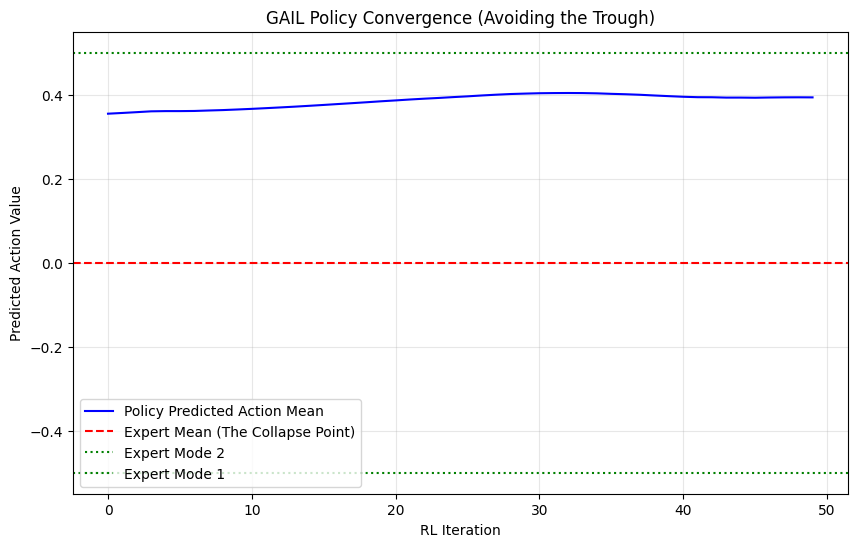

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt # Needed for visualization in Colab

# --- Configuration ---
STATE_DIM = 1
ACTION_DIM = 1
DISCOUNT_FACTOR = 0.99
GAIL_EPOCHS = 5
BATCH_SIZE = 64
test_state = torch.tensor([[1.0]], dtype=torch.float32)

# --- 1. Model Definitions (Policy and Discriminator classes remain the same) ---
class Discriminator(nn.Module):
    # ... (same as before)
    def __init__(self, state_dim, action_dim):
        super(Discriminator, self).__init__()
        input_size = state_dim + action_dim
        self.net = nn.Sequential(nn.Linear(input_size, 64),nn.Tanh(),nn.Linear(64, 64),nn.Tanh(),nn.Linear(64, 1),nn.Sigmoid())
    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        return self.net(x)

class Policy(nn.Module):
    # ... (same as before)
    def __init__(self, state_dim, action_dim):
        super(Policy, self).__init__()
        self.net = nn.Sequential(nn.Linear(state_dim, 64),nn.ReLU(),nn.Linear(64, action_dim),nn.Tanh())
    def forward(self, state):
        return self.net(state)

# --- 2. Expert Data Simulation (Multimodal Expert) ---
def get_expert_data(num_samples):
    states = np.ones((num_samples, STATE_DIM), dtype=np.float32)
    N = num_samples // 2
    actions_m1 = np.random.normal(-0.5, 0.1, (N, ACTION_DIM))
    actions_m2 = np.random.normal(0.5, 0.1, (N, ACTION_DIM))
    actions = np.concatenate([actions_m1, actions_m2], axis=0).astype(np.float32)
    indices = np.arange(num_samples); np.random.shuffle(indices)
    states = torch.tensor(states[indices], dtype=torch.float32)
    actions = torch.tensor(actions[indices], dtype=torch.float32)
    return states, actions

# --- 3. GAIL Adversarial Update Logic (Fixed) ---

def update_discriminator(discriminator, policy, expert_states, expert_actions):
    disc_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3)
    criterion = nn.BCELoss()

    expert_labels = torch.ones(expert_states.size(0), 1)

    # Generate Agent Data (crucial: detach policy for discriminator update only)
    with torch.no_grad():
        agent_actions = policy(expert_states).detach()
    agent_labels = torch.zeros(expert_states.size(0), 1)

    all_states = torch.cat([expert_states, expert_states], dim=0)
    all_actions = torch.cat([expert_actions, agent_actions], dim=0)
    all_labels = torch.cat([expert_labels, agent_labels], dim=0)

    # Train the Discriminator
    for _ in range(GAIL_EPOCHS):
        idx = torch.randperm(all_states.size(0))
        for start_idx in range(0, all_states.size(0), BATCH_SIZE):
            end_idx = min(start_idx + BATCH_SIZE, all_states.size(0))

            states_batch = all_states[idx[start_idx:end_idx]]
            actions_batch = all_actions[idx[start_idx:end_idx]]
            labels_batch = all_labels[idx[start_idx:end_idx]]

            disc_optimizer.zero_grad()
            predictions = discriminator(states_batch, actions_batch)
            loss = criterion(predictions, labels_batch)
            loss.backward()
            disc_optimizer.step()

    return loss.item()

# --- 4. Main GAIL Simulation ---

if __name__ == '__main__':

    # Setup
    discriminator = Discriminator(STATE_DIM, ACTION_DIM)
    policy = Policy(STATE_DIM, ACTION_DIM)
    policy_optimizer = optim.Adam(policy.parameters(), lr=1e-4) # Policy Optimizer

    EXPERT_SAMPLES = 10000
    expert_states, expert_actions = get_expert_data(EXPERT_SAMPLES)

    print("Expert Data: Multimodal actions around -0.5 and +0.5")
    print(f"Expert mean (The Collapse Point): {expert_actions.mean().item():.4f}")

    NUM_RL_ITERATIONS = 50
    policy_mean_history = []

    for i in range(NUM_RL_ITERATIONS):

        # --- PHASE 1 & 2: Policy Update (Simulated RL Step) ---

        agent_states = expert_states[:500]

        # 1. Freeze Discriminator and Prepare for Policy Update
        for param in discriminator.parameters():
            param.requires_grad = False

        policy_optimizer.zero_grad()

        # 2. Forward pass for the policy and reward calculation
        agent_actions = policy(agent_states)

        # The reward is log(D(s,a)). Policy maximizes this.
        predictions = discriminator(agent_states, agent_actions)
        predictions = torch.clamp(predictions, 1e-8, 1.0)

        policy_loss = -torch.log(predictions).mean() # Policy minimizes negative log likelihood

        # 3. Backward Pass and Update
        policy_loss.backward() # This now flows gradient to policy parameters
        policy_optimizer.step()

        # 4. Unfreeze Discriminator
        for param in discriminator.parameters():
            param.requires_grad = True

        # --- PHASE 3: Discriminator Update ---
        disc_loss = update_discriminator(discriminator, policy, expert_states, expert_actions)

        # --- Logging and Analysis ---
        predicted_action_mean = policy(test_state).item()
        policy_mean_history.append(predicted_action_mean)

        if (i + 1) % 10 == 0:
            print(f"Iteration {i+1}/{NUM_RL_ITERATIONS}:")
            print(f"  Discriminator Loss: {disc_loss:.4f}")
            print(f"  Policy Predicted Action: {predicted_action_mean:.4f}")

    # --- Final Analysis ---
    final_policy_action = policy(test_state).item()

    print("\n--- GAIL Final Result ---")
    print(f"Final Policy Action: {final_policy_action:.4f}")

    if abs(final_policy_action) > 0.3:
        print("\n**SUCCESS: GAIL AVOIDED THE MULTIMODAL COLLAPSE (0.0).**")
    else:
        print("\nNote: The Policy is deterministic and struggles to fully represent both modes simultaneously.")

    # --- Visualization of Policy Convergence (Colab Compatible) ---
    plt.figure(figsize=(10, 6))
    plt.plot(policy_mean_history, label='Policy Predicted Action Mean', color='blue')
    plt.axhline(0.0, color='red', linestyle='--', label='Expert Mean (The Collapse Point)')
    plt.axhline(0.5, color='green', linestyle=':', label='Expert Mode 2')
    plt.axhline(-0.5, color='green', linestyle=':', label='Expert Mode 1')
    plt.title('GAIL Policy Convergence (Avoiding the Trough)')
    plt.xlabel('RL Iteration')
    plt.ylabel('Predicted Action Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

<h4>21:33 </h4>

<h3>Learning distributions with neural networks</h3>


<ol>
Can we use generative modeling?
<li>GMMs</li>
<li>Diffusion model over actions instead of Diffusion over images</li>
<li>discretized autoregressive model as an alternative to GMMs</li>
</ol>

<br />
<br />

<ul>
<li>Can use ideas from diffusion and autoregressive generative models to learn actions over observations or given states</li>
<li>Goal, approximate p(a) given s; p(a|s) </li>
<li>Start with mixture of gaussians, NN will output the parameters of GMM. $\mu_1,\sigma_1, W_1... $</li>
<li>Example: given a dataset which are (state, action) pairs. Sample (s,a) pair. We want to minimize -log()</li>
</ul>



# **Multihead Conditional Factorization**

<b>Joint and Conditional Probabilies</b>
<p>How to model a joint distibution, $p(X,Y)$? </p>

<p>A joint distribtion is a probability distribution for multiple RVs. Example, rolling N dice where N > 1. It describes all possible states and probabilities of the RVs.  </p>

<ul>
<b>Independent Joint Probabilities</b>
<li>Joint probabilities, Joint Probability of multiple  random variables. Minimium is 2 RVs modeled by throwing 2 dice P(X,Y) and tabulating the probability of each combination. </li>
<li>A JP of 2 dice is $P(X, Y)={(1,Y),(2,Y),(3,Y),(4,Y),(5,Y),(6,Y)}$ is 36 states once all 6 states of Y are enumerated. Note the methodology; fix one RV then sample over the second one. To determine probabilities, since they are independent, P(X,Y)=1/36. </li>
<li>What is the probability of a 7? Enumerate {(1,6)(6,1),(2,5),(5,2),(3,4),(4,3)}. Note this is an upper or lower triangular matrix. We only need to enumerate the first RV from 1->4 if we use symmetry to automatically list the other state. A state of (1,6) automatically includes (6,1) by symmetery. We need this symmetrty when calculating attention in matrix form. </li>
<li>What are the assumptions for the JP? Independent. This is the bag of words model in NLP</li>
<b>Joint probability of independent RVs</b>
<li>Independence of RVs means the joint probablity $P(X,Y)=P(X)*P(Y)$</li>
</ul>

<ul>
<b>Conditional Probability</b>
<li>Conditional Probablity between 2 dice is when one is rolled first and the state recorded before the second roll. We need this for modeling sequential tokens in a sentence. </li>
<li>Definition of a conditional probability is $P(X|Y)=\frac{P(X,Y)}{P(Y)}$ We need the joint probability to compute the conditional probability. P(Y) is the marginal probability. </li>
<li>Conditional probability does not require the RVs to be independent. </li>
<li>What is the probability of a 7 if the first roll is a 3? X = sum is 7. Y is first roll is a 3. P(X|Y)=P(X,Y)/P(Y). P(X,Y) is 1/36 since there are 36 possible combinations. P(Y) is the probabiity of 3 for 1 dice = 1/6. P(X|y)= (1/36)/(1/6)=1/6</li>
<li>P(X|Y)=P(Y|X) is not true. Bayes Rule relates the order of conditional probabilites. $P(X \mid Y)=\frac{P(Y \mid X)\,P(X)}{P(Y)}$</li>
<li>Important take away is independence of RVs is not assumed</li>
</ul>



<b>Chain rule probability</b>
<ul>
<li>Derived from Bayes rule implies chain rule does not require the RVs to be independent. </li>
<li>The chain rule is derived from the above conditional probablity rule by muitiplying both sides by P(Y), $P(X,Y)=P(Y)P(X|Y)$</li>
<li>Swap RVs $P(X,Y)=P(Y)P(X|Y)=P(X)P(Y|X)$ Careful this does not imply P(X,Y) = P(Y,X). When using Bayes rule the denominator cannot be 0.  </li>
<li>Why do we need this? For NNs predicting multiple CORRELATED outputs.  </li>
<li>Output multiple correlated outputs from a NN. </li>
<li>$P(X_1, X_2, \ldots, X_n)
=
P(X_1)\,
P(X_2 \mid X_1)\,
P(X_3 \mid X_1, X_2)\,
\cdots\,
P(X_n \mid X_1, X_2, \ldots, X_{n-1})$</li>
<li>Multihead Conditional Factorization implemented in a NN does not require the features to be independent because it is derived from Bayes rule</li>
<li>LLMs are autoregressive conditional probabilites. The non autoregressive verison of conditional probability from CM's NLP class 20y ago. LLMs use the chain rule to model autoregressive over time not across features.  </li>
<li>Multihead conditional factorization have many applications. </li>
</ul>



<b>Dependent Joint Probabillities. </b>
<ul>
<li>Dependent Joint RVs mean the Joint probabiltiy defintion $P(X)*P(Y)$ is no longer applicable$</li>
<li>We have to use Bayes rule to get the JP!!!!</li>
<li>$P(X,Y)=P(Y)*P(X|Y)$</li>
</ul>


<b>Dependent features Model Example</b>

<ul>
<b>Statistical Dependence using Dice</b>
<li>We need to distinguish between token dependency which is modeled by attention vs. statistical dependence which is modeled by multiple dice over multiple trials. </li>
<li>NN pytorch example for 4 dependent dice. This will make the concept of statistical dependence clear in the context of a NN> </li>
</ul>

<ul>
Create some dependent data. Featurs are correlated
 <table>
  <tr>
    <th>Trial</th>
    <th>Dice1</th>
    <th>Dice2</th>
    <th>Dice3</th>
    <th>Dice4</th>
    
  </tr>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>1</td>
    <td>1</td>
    <td>1</td>
  </tr>
  <tr>
    <td>2</td>
    <td>3</td>
    <td>3</td>
    <td>4</td>
    <td>4</td>
  </tr>
  <tr>
    <td>3</td>
    <td>5</td>
    <td>5</td>
    <td>6</td>
    <td>6</td>
  </tr>
  <tr>
    <td>4</td>
    <td>2</td>
    <td>2</td>
    <td>3</td>
    <td>3</td>
  </tr>
  <tr>
    <td>5</td>
    <td>4</td>
    <td>4</td>
    <td>5</td>
    <td>5</td>
  </tr>
  <tr>
    <td>6</td>
    <td>6</td>
    <td>6</td>
    <td>1</td>
    <td>1</td>
  </tr>
  <tr>
    <td>7</td>
    <td>1</td>
    <td>1</td>
    <td>2</td>
    <td>2</td>
  </tr>
  <tr>
    <td>8</td>
    <td>3</td>
    <td>3</td>
    <td>4</td>
    <td>4</td>
  </tr>
  <tr>
    <td>9</td>
    <td>5</td>
    <td>5</td>
    <td>6</td>
    <td>6</td>
  </tr>
  <tr>
    <td>10</td>
    <td>2</td>
    <td>2</td>
    <td>3</td>
    <td>3</td>
  </tr>

</table>
<li>Dice2=Dice1</li>
<li>D3 ≈ D1 + 1</li>
<li>D4=D3</li>
<li>Independent factorization $P(D1, D2, D3, D4) = P(D1)*P(D2)*P(D3)*P(D4)$</li>
<li>Dependent factorization $P(D1, D2, D3, D4) = P(D1)*P(D2|D1)*P(D3|D1,D2)*P(D4|D1,D2,D3) $</li>
</ul>


<ul>
<li>The statistical dependence for 4 dice is not the same as the dependency between tokens in a sentence. Token dependencies are contextual, directed, nonsymmetric, position dependent. Those are modled via attention. If we strip away parts of attention like position then we have multiple permutations of tokens with equal probabilities.</li>


<li>Create a pytorch example of learning both a joint probability from data and a conditional probability factorization of 2 dice with the sum equal to 7.</li>


<li>The comparison of joint model vs. conditional factorization of 2 dice is a smaller example of a autoregressive LLM, $p(y_1,\dots,y_T) = \prod_t p(y_t\mid y_{<t})$</li>
</ul>

<b>
<ul>
<li>Evolve designs which are more expressive. Lecture 2: xx.xx</li>
<li>The conditional factorization is more expressive than the joint probability because it can represent more models than the joint distribution.</li>
<li>autoregressive models use conditional factorization </li>
</ul>
</b>

<b>Independent vs dependent or correlated models</b>
<ul>
<li>independent features, bag of words models like LDA for topic modeling are do not perform as well as sequence dependent subword token models like LLMs</li>
<li>Topic modeling using a LLM is far more accurate than LDA BOW models</li>
</ul>

<ul>
<b>Multihead Conditional Factorizaiton is the Chain rule applied across multiple input features</b>
<li>MCF does not require the features to be independent. </li>
	<li>	Head 1 predicts $P(X_1)$</li>
	<li>	Head 2 predicts $P(X_2\mid X_1)$</li>
	<li>	Head 3 predicts $P(X_3\mid X_1,X_2)$</li>
	<li>  Head 4 predicts $P(X_4\mid X_1,X_2,X_3)$</li>
</ul>


In [5]:
# pytorch joint probability
import torch

P_x = torch.full((6,),1/6)
P_y = torch.full((6,),1/6)

print(P_x)
print(P_y)
jp = P_x * P_y

tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])


In [1]:
# modeling a dependent joint probbility distribution
# 4 dice 10 trials

#	D2 = D1
#	•	D3 = f(D1)
#	•	D4 = D3

# Colab-ready PyTorch demo:
# Conditional multi-head factorization vs independent heads
# on a toy 4-dice correlated dataset.

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------
# 1. Toy 4-dice, 10-trial dataset
# ---------------------------

# We encode dice outcomes as integers in {0,...,5} for values {1,...,6}.
# Correlated rules:
# D2 = D1
# D3 = (D1 + 1) mod 6
# D4 = D3

def make_base_trials():
    # 10 base trials using D1 in some pattern
    d1_values = torch.tensor([0, 2, 4, 1, 3, 5, 0, 2, 4, 1])  # 1,3,5,2,4,6,1,3,5,2 (minus 1)
    d2 = d1_values.clone()
    d3 = (d1_values + 1) % 6
    d4 = d3.clone()
    y = torch.stack([d1_values, d2, d3, d4], dim=1)  # shape (10,4)
    return y

base_y = make_base_trials()

print("Base 10 trials (values 0..5):")
print(base_y)
print("Decoded as 1..6:")
print(base_y + 1)

# Create a bigger dataset by repeating the 10 trials many times
num_repeats = 200   # 10 * 200 = 2000 samples
y_full = base_y.repeat(num_repeats, 1)  # (2000,4)

N = y_full.size(0)
print("Full dataset size:", N)


# ---------------------------
# 2. Simple Dataset + DataLoader
# ---------------------------

class DiceDataset(Dataset):
    def __init__(self, y):
        # inputs x are trivial here; we only care about modeling y.
        # We can just use a dummy scalar feature 0.0 for all samples.
        self.x = torch.zeros((y.size(0), 1), dtype=torch.float32)
        self.y = y.long()

    def __len__(self):
        return self.y.size(0)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = DiceDataset(y_full)

# Split into train/test
perm = torch.randperm(N)
train_size = int(0.8 * N)
train_idx = perm[:train_size]
test_idx  = perm[train_size:]

train_ds = DiceDataset(y_full[train_idx])
test_ds  = DiceDataset(y_full[test_idx])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)


# ---------------------------
# 3. Independent multi-head model
#    p(D1)p(D2)p(D3)p(D4) (no conditioning)
# ---------------------------

class IndependentDiceNet(nn.Module):
    def __init__(self, in_dim=1, hidden=32, num_classes=6, num_dice=4):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )
        self.heads = nn.ModuleList([nn.Linear(hidden, num_classes) for _ in range(num_dice)])

    def forward(self, x):
        # x: (B, in_dim)
        h = self.shared(x)
        logits = [head(h) for head in self.heads]  # list of (B,6)
        return logits  # length 4

ind_model = IndependentDiceNet().to(device)


# ---------------------------
# 4. Conditional multi-head model (autoregressive over dice)
#    p(D1) p(D2|D1) p(D3|D1,D2) p(D4|D1,D2,D3)
#    Uses embeddings of previous dice as conditioning inputs.
# ---------------------------

class ConditionalDiceNet(nn.Module):
    def __init__(self, in_dim=1, hidden=64, num_classes=6, num_dice=4, emb_dim=8):
        super().__init__()
        self.num_dice = num_dice
        self.num_classes = num_classes

        # Embedding for each dice face (0..5)
        self.emb = nn.Embedding(num_classes, emb_dim)

        # For each step t, we build a small network that takes:
        # [x, emb(D1), emb(D2), ... emb(D_{t-1})] as input.
        self.nets = nn.ModuleList()
        for t in range(num_dice):
            # step t sees x plus t embeddings
            in_features = in_dim + t * emb_dim
            net = nn.Sequential(
                nn.Linear(in_features, hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.ReLU(),
                nn.Linear(hidden, num_classes),
            )
            self.nets.append(net)

    def forward(self, x, y=None):
        """
        x: (B, in_dim)
        y: (B,4) ground truth dice (0..5) for teacher forcing
        Returns list of logits [logits_d1, logits_d2, logits_d3, logits_d4],
        each (B,6).
        """
        B = x.size(0)
        cond = x  # initial condition is just x
        logits_list = []
        prev_embs = []

        for t in range(self.num_dice):
            # cond = [x, emb(D1), ..., emb(D_{t})? we use ground truth y for teacher forcing]
            if t > 0:
                # append embedding of y[:, t-1]
                e = self.emb(y[:, t-1])  # (B, emb_dim)
                prev_embs.append(e)
                cond = torch.cat([x] + prev_embs, dim=1)
            else:
                cond = x  # no previous dice yet

            logits_t = self.nets[t](cond)  # (B,6)
            logits_list.append(logits_t)

        return logits_list  # length 4

cond_model = ConditionalDiceNet().to(device)


# ---------------------------
# 5. Training utilities
# ---------------------------

def train_epoch_independent(model, loader, optim):
    model.train()
    total_loss = 0.0
    total_count = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)  # (B,4)

        optim.zero_grad()
        logits_list = model(x)  # list of 4 tensors (B,6)
        loss = 0.0
        for d in range(4):
            loss += F.cross_entropy(logits_list[d], y[:, d])
        loss.backward()
        optim.step()

        total_loss += loss.item() * x.size(0)
        total_count += x.size(0)

    return total_loss / total_count


def train_epoch_conditional(model, loader, optim):
    model.train()
    total_loss = 0.0
    total_count = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optim.zero_grad()
        logits_list = model(x, y)  # teacher forcing
        loss = 0.0
        for d in range(4):
            loss += F.cross_entropy(logits_list[d], y[:, d])
        loss.backward()
        optim.step()

        total_loss += loss.item() * x.size(0)
        total_count += x.size(0)

    return total_loss / total_count


def eval_model(model, loader, conditional=False):
    model.eval()
    total_loss = 0.0
    total_count = 0

    all_true = []
    all_pred = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            if conditional:
                logits_list = model(x, y)
            else:
                logits_list = model(x)

            loss = 0.0
            preds = []
            for d in range(4):
                loss += F.cross_entropy(logits_list[d], y[:, d])
                preds.append(logits_list[d].argmax(dim=1))  # (B,)

            total_loss += loss.item() * x.size(0)
            total_count += x.size(0)

            preds = torch.stack(preds, dim=1)  # (B,4)
            all_true.append(y.cpu())
            all_pred.append(preds.cpu())

    all_true = torch.cat(all_true, dim=0)
    all_pred = torch.cat(all_pred, dim=0)
    avg_loss = total_loss / total_count

    # Measure how well correlations are captured:
    # 1) D2 == D1
    # 2) D4 == D3
    corr1_true = (all_true[:, 1] == all_true[:, 0]).float().mean().item()
    corr1_pred = (all_pred[:, 1] == all_pred[:, 0]).float().mean().item()

    corr2_true = (all_true[:, 3] == all_true[:, 2]).float().mean().item()
    corr2_pred = (all_pred[:, 3] == all_pred[:, 2]).float().mean().item()

    return {
        "loss": avg_loss,
        "corr_true_D2_eq_D1": corr1_true,
        "corr_pred_D2_eq_D1": corr1_pred,
        "corr_true_D4_eq_D3": corr2_true,
        "corr_pred_D4_eq_D3": corr2_pred,
        "true": all_true,
        "pred": all_pred,
    }


# ---------------------------
# 6. Train both models
# ---------------------------

ind_optim = torch.optim.Adam(ind_model.parameters(), lr=1e-3)
cond_optim = torch.optim.Adam(cond_model.parameters(), lr=1e-3)

num_epochs = 50

print("\nTraining Independent Heads model...")
for epoch in range(1, num_epochs + 1):
    loss_tr = train_epoch_independent(ind_model, train_loader, ind_optim)
    if epoch % 10 == 0 or epoch == 1:
        metrics = eval_model(ind_model, test_loader, conditional=False)
        print(
            f"[Ind] Epoch {epoch:02d} | "
            f"train_loss={loss_tr:.4f}, "
            f"test_loss={metrics['loss']:.4f}, "
            f"D2=D1(pred)={metrics['corr_pred_D2_eq_D1']:.3f}, "
            f"D4=D3(pred)={metrics['corr_pred_D4_eq_D3']:.3f}"
        )

print("\nTraining Conditional Heads model...")
for epoch in range(1, num_epochs + 1):
    loss_tr = train_epoch_conditional(cond_model, train_loader, cond_optim)
    if epoch % 10 == 0 or epoch == 1:
        metrics = eval_model(cond_model, test_loader, conditional=True)
        print(
            f"[Cond] Epoch {epoch:02d} | "
            f"train_loss={loss_tr:.4f}, "
            f"test_loss={metrics['loss']:.4f}, "
            f"D2=D1(pred)={metrics['corr_pred_D2_eq_D1']:.3f}, "
            f"D4=D3(pred)={metrics['corr_pred_D4_eq_D3']:.3f}"
        )

# ---------------------------
# 7. Sample from the two models (to see mismatches)
# ---------------------------

def sample_independent(model, num_samples=10):
    model.eval()
    with torch.no_grad():
        x = torch.zeros((num_samples, 1), device=device)
        logits_list = model(x)
        preds = [logits.argmax(dim=1) for logits in logits_list]
        preds = torch.stack(preds, dim=1)  # (B,4)
    return preds.cpu()

def sample_conditional(model, num_samples=10):
    model.eval()
    with torch.no_grad():
        x = torch.zeros((num_samples, 1), device=device)
        # We need to sample sequentially, feeding previous samples back.
        B = num_samples
        y_samp = torch.zeros((B, 4), dtype=torch.long, device=device)

        # Step 1: sample D1 from p(D1|x)
        logits_t = model.nets[0](x)
        y1 = logits_t.softmax(dim=1).multinomial(num_samples=1).squeeze(1)
        y_samp[:, 0] = y1

        # Step 2-4: use sampled previous dice as conditioning
        prev_embs = []
        for t in range(1, 4):
            e = model.emb(y_samp[:, t-1])
            prev_embs.append(e)
            cond = torch.cat([x] + prev_embs, dim=1)
            logits_t = model.nets[t](cond)
            yt = logits_t.softmax(dim=1).multinomial(num_samples=1).squeeze(1)
            y_samp[:, t] = yt

    return y_samp.cpu()

print("\nSampling 10 sequences from Independent model (decoded 1..6):")
samples_ind = sample_independent(ind_model, num_samples=10)
print(samples_ind + 1)
print("D2==D1:", (samples_ind[:,1] == samples_ind[:,0]))
print("D4==D3:", (samples_ind[:,3] == samples_ind[:,2]))

print("\nSampling 10 sequences from Conditional model (decoded 1..6):")
samples_cond = sample_conditional(cond_model, num_samples=10)
print(samples_cond + 1)
print("D2==D1:", (samples_cond[:,1] == samples_cond[:,0]))
print("D4==D3:", (samples_cond[:,3] == samples_cond[:,2]))

Using device: cpu
Base 10 trials (values 0..5):
tensor([[0, 0, 1, 1],
        [2, 2, 3, 3],
        [4, 4, 5, 5],
        [1, 1, 2, 2],
        [3, 3, 4, 4],
        [5, 5, 0, 0],
        [0, 0, 1, 1],
        [2, 2, 3, 3],
        [4, 4, 5, 5],
        [1, 1, 2, 2]])
Decoded as 1..6:
tensor([[1, 1, 2, 2],
        [3, 3, 4, 4],
        [5, 5, 6, 6],
        [2, 2, 3, 3],
        [4, 4, 5, 5],
        [6, 6, 1, 1],
        [1, 1, 2, 2],
        [3, 3, 4, 4],
        [5, 5, 6, 6],
        [2, 2, 3, 3]])
Full dataset size: 2000

Training Independent Heads model...
[Ind] Epoch 01 | train_loss=7.1748, test_loss=7.1202, D2=D1(pred)=0.000, D4=D3(pred)=0.000
[Ind] Epoch 10 | train_loss=6.9815, test_loss=7.0485, D2=D1(pred)=1.000, D4=D3(pred)=1.000
[Ind] Epoch 20 | train_loss=6.9822, test_loss=7.0532, D2=D1(pred)=1.000, D4=D3(pred)=1.000
[Ind] Epoch 30 | train_loss=6.9817, test_loss=7.0516, D2=D1(pred)=1.000, D4=D3(pred)=1.000
[Ind] Epoch 40 | train_loss=6.9808, test_loss=7.0524, D2=D1(pred)=1.

Expected direct loss ~ 3.58351893845611
Expected factorized loss ~ 3.58351893845611
Final direct loss: 3.5847842070007325
Final fact loss: 3.5843469415283202
Max abs err (direct joint vs true): 0.0032469742000102997
Max abs err (fact joint vs true):   0.0015206187963485718


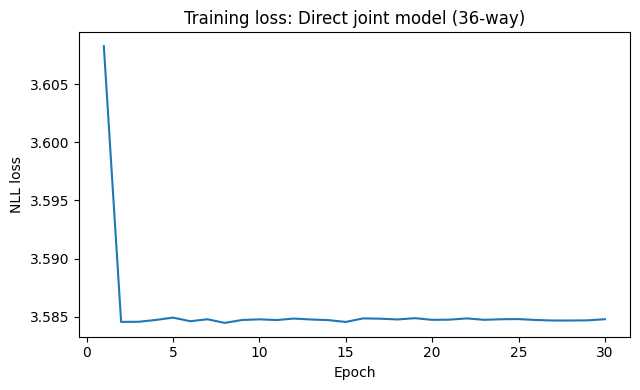

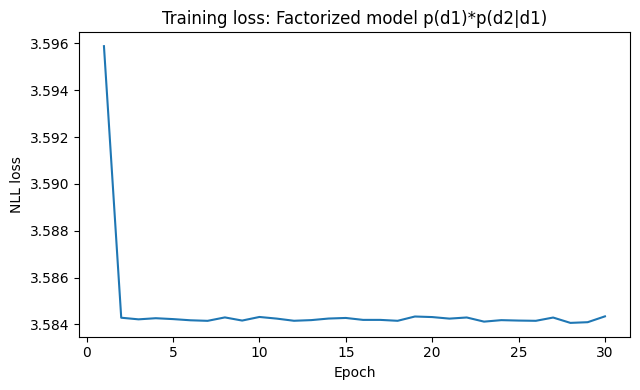

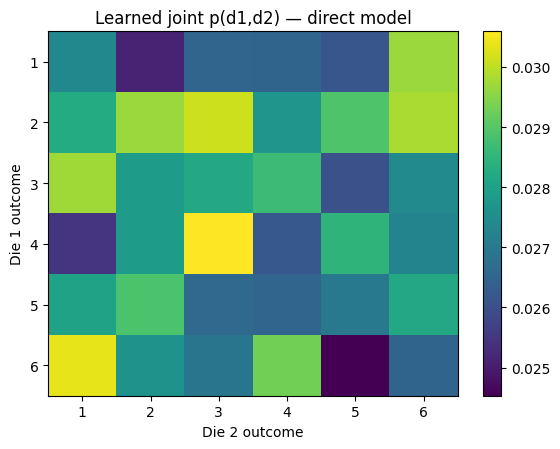

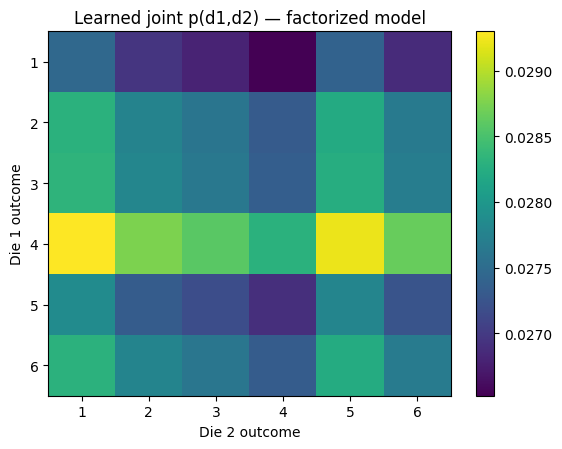

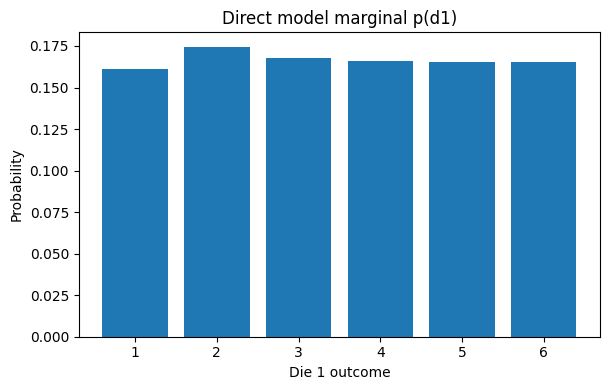

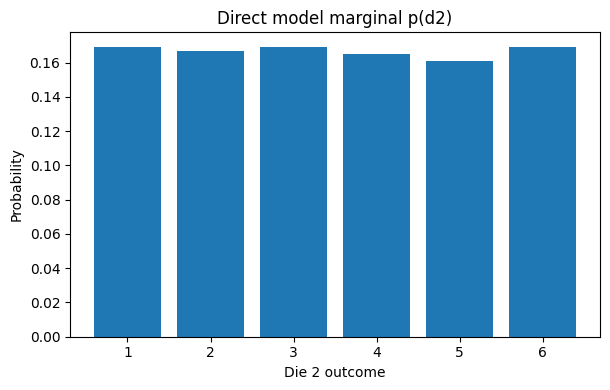

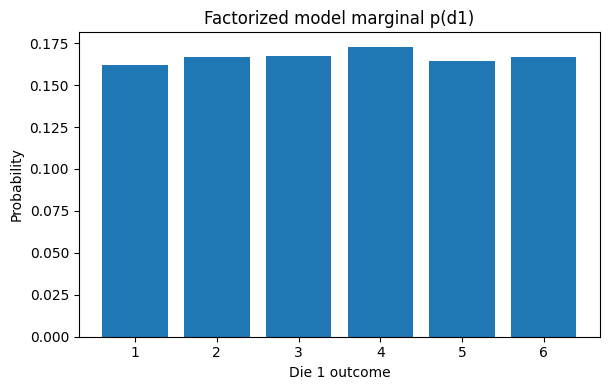

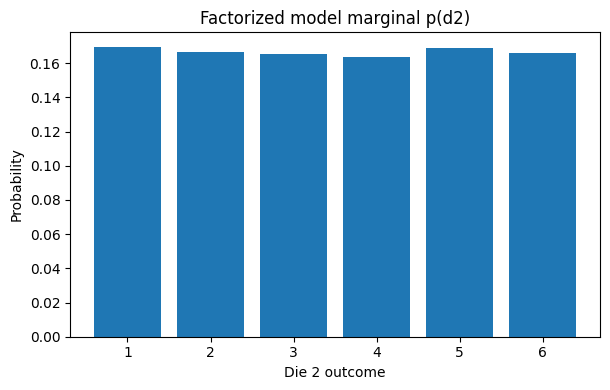

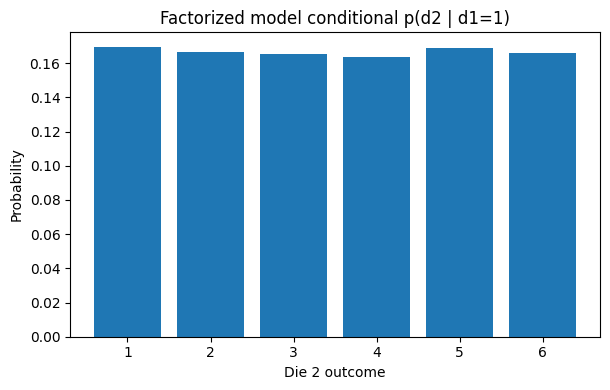

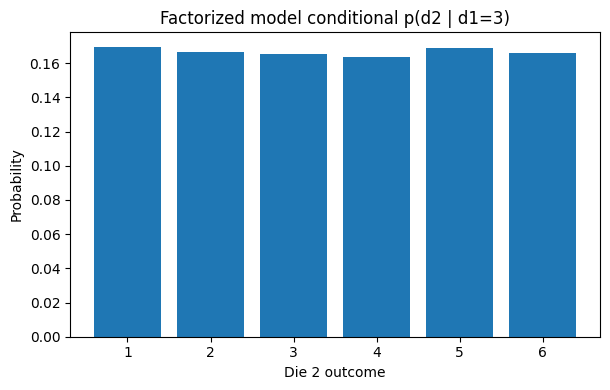

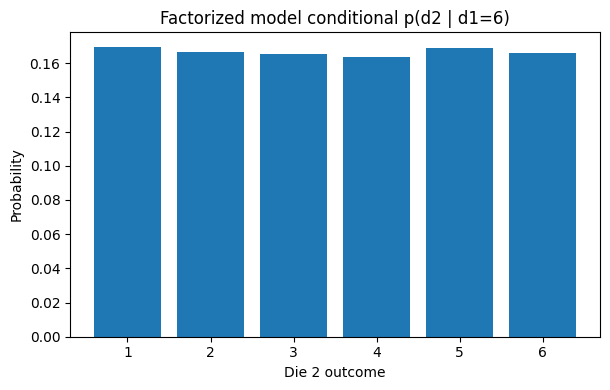

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# -----------------------------
# 0) Repro
# -----------------------------
torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# 1) Data: two fair independent dice
# -----------------------------
def generate_dice_data(num_samples: int):
    d1 = np.random.randint(1, 7, size=num_samples)  # 1..6
    d2 = np.random.randint(1, 7, size=num_samples)

    X = torch.ones(num_samples, 1, dtype=torch.float32)  # dummy feature

    # direct target: 0..35 index
    y_direct = torch.tensor((d1 - 1) * 6 + (d2 - 1), dtype=torch.long)

    # factorized targets: d1_idx, d2_idx in 0..5
    y_d1 = torch.tensor(d1 - 1, dtype=torch.long)
    y_d2 = torch.tensor(d2 - 1, dtype=torch.long)

    return X, y_direct, y_d1, y_d2

NUM_SAMPLES = 100_000
BATCH_SIZE  = 512
NUM_EPOCHS  = 30
LR          = 1e-2

X, y_direct, y_d1, y_d2 = generate_dice_data(NUM_SAMPLES)

loader_direct = DataLoader(TensorDataset(X, y_direct), batch_size=BATCH_SIZE, shuffle=True)
loader_fact   = DataLoader(TensorDataset(X, y_d1, y_d2), batch_size=BATCH_SIZE, shuffle=True)

# Ground-truth joint for fair dice
true_joint = torch.full((6, 6), 1.0 / 36.0)

# -----------------------------
# 2) Model A: Direct joint p(d1,d2) as 36-way softmax
# -----------------------------
class DirectJointModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(1, 36)

    def forward(self, x):
        return self.fc(x)  # logits [B,36]

    @torch.no_grad()
    def joint_table(self):
        logits = self(torch.ones(1,1, device=device)).squeeze(0)  # [36]
        p = torch.softmax(logits, dim=-1).view(6, 6)
        return p.cpu()

# -----------------------------
# 3) Model B: Conditional factorization p(d1)*p(d2|d1)
# -----------------------------
class ConditionalFactorModel(nn.Module):
    def __init__(self, d1_emb_dim=8, hidden_dim=32):
        super().__init__()
        # head for p(d1)
        self.fc_d1 = nn.Linear(1, 6)

        # conditioning for p(d2|d1): embed d1 and combine with x (dummy)
        self.d1_emb = nn.Embedding(6, d1_emb_dim)
        self.fc = nn.Sequential(
            nn.Linear(1 + d1_emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 6),
        )

    def forward(self, x, d1_idx=None):
        # logits for d1
        logits_d1 = self.fc_d1(x)  # [B,6]

        # teacher forcing for training of p(d2|d1)
        if d1_idx is None:
            d1_idx = logits_d1.argmax(dim=-1)  # greedy for inference

        e = self.d1_emb(d1_idx)  # [B,emb]
        logits_d2 = self.fc(torch.cat([x, e], dim=-1))  # [B,6]
        return logits_d1, logits_d2

    @torch.no_grad()
    def joint_table(self):
        # Build joint by: p(d1) and p(d2|d1) for each d1
        x = torch.ones(1,1, device=device)  # dummy
        logits_d1, _ = self.forward(x, d1_idx=torch.zeros(1, dtype=torch.long, device=device))
        p_d1 = torch.softmax(logits_d1.squeeze(0), dim=-1)  # [6]

        # compute p(d2|d1=i) row by row
        rows = []
        for i in range(6):
            d1_idx = torch.tensor([i], dtype=torch.long, device=device)
            _, logits_d2 = self.forward(x, d1_idx=d1_idx)
            p_d2_given = torch.softmax(logits_d2.squeeze(0), dim=-1)  # [6]
            rows.append(p_d2_given.cpu())
        p_d2_given_d1 = torch.stack(rows, dim=0)  # [6,6]
        joint = (p_d1.cpu()[:, None] * p_d2_given_d1)  # [6,6]
        return joint, p_d1.cpu(), p_d2_given_d1

# -----------------------------
# 4) Train both + record losses
# -----------------------------
def train_direct():
    model = DirectJointModel().to(device)
    opt = optim.Adam(model.parameters(), lr=LR)
    crit = nn.CrossEntropyLoss()
    losses = []

    for ep in range(NUM_EPOCHS):
        model.train()
        running = 0.0
        n = 0
        for xb, yb in loader_direct:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()
            running += loss.item() * xb.size(0)
            n += xb.size(0)
        losses.append(running / n)
    return model, losses

def train_factorized():
    model = ConditionalFactorModel().to(device)
    opt = optim.Adam(model.parameters(), lr=LR)
    crit = nn.CrossEntropyLoss()
    losses = []

    for ep in range(NUM_EPOCHS):
        model.train()
        running = 0.0
        n = 0
        for xb, d1b, d2b in loader_fact:
            xb, d1b, d2b = xb.to(device), d1b.to(device), d2b.to(device)
            opt.zero_grad()
            logits_d1, logits_d2 = model(xb, d1_idx=d1b)  # teacher forcing
            loss1 = crit(logits_d1, d1b)
            loss2 = crit(logits_d2, d2b)
            loss = loss1 + loss2
            loss.backward()
            opt.step()
            running += loss.item() * xb.size(0)
            n += xb.size(0)
        losses.append(running / n)
    return model, losses

model_direct, losses_direct = train_direct()
model_fact, losses_fact = train_factorized()

# Expected NLLs for fair dice
expected_direct = -math.log(1/36)          # ~ 3.5835
expected_fact   = -math.log(1/6) * 2       # ~ 3.5835

print("Expected direct loss ~", expected_direct)
print("Expected factorized loss ~", expected_fact)
print("Final direct loss:", losses_direct[-1])
print("Final fact loss:", losses_fact[-1])

# -----------------------------
# 5) Extract learned distributions + correctness checks
# -----------------------------
with torch.no_grad():
    p_joint_direct = model_direct.joint_table()  # [6,6]

    p_joint_fact, p_d1, p_d2_given_d1 = model_fact.joint_table()  # [6,6], [6], [6,6]

# Basic checks (tolerances: these are learned from finite samples)
def max_abs_err(a, b): return (a - b).abs().max().item()

print("Max abs err (direct joint vs true):", max_abs_err(p_joint_direct, true_joint))
print("Max abs err (fact joint vs true):  ", max_abs_err(p_joint_fact, true_joint))

# -----------------------------
# 6) Plotting helpers (one figure per chart)
# -----------------------------
def plot_loss_curve(losses, title):
    plt.figure(figsize=(6.5, 4.0))
    plt.plot(np.arange(1, len(losses)+1), losses)
    plt.xlabel("Epoch")
    plt.ylabel("NLL loss")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_heatmap(mat, title):
    plt.figure(figsize=(5.8, 4.6))
    plt.imshow(mat.numpy(), aspect="auto")
    plt.colorbar()
    plt.xticks(range(6), [str(i) for i in range(1, 7)])
    plt.yticks(range(6), [str(i) for i in range(1, 7)])
    plt.xlabel("Die 2 outcome")
    plt.ylabel("Die 1 outcome")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_bar(p, title, xlabel):
    plt.figure(figsize=(6.2, 4.0))
    plt.bar(range(1, 7), p.numpy())
    plt.xticks(range(1, 7))
    plt.xlabel(xlabel)
    plt.ylabel("Probability")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 7) Graphs
# -----------------------------
plot_loss_curve(losses_direct, "Training loss: Direct joint model (36-way)")
plot_loss_curve(losses_fact,   "Training loss: Factorized model p(d1)*p(d2|d1)")

plot_heatmap(p_joint_direct, "Learned joint p(d1,d2) — direct model")
plot_heatmap(p_joint_fact,   "Learned joint p(d1,d2) — factorized model")

plot_bar(p_joint_direct.sum(dim=1), "Direct model marginal p(d1)", "Die 1 outcome")
plot_bar(p_joint_direct.sum(dim=0), "Direct model marginal p(d2)", "Die 2 outcome")

plot_bar(p_joint_fact.sum(dim=1), "Factorized model marginal p(d1)", "Die 1 outcome")
plot_bar(p_joint_fact.sum(dim=0), "Factorized model marginal p(d2)", "Die 2 outcome")

# Show a couple example conditionals p(d2 | d1=i)
for i in [0, 2, 5]:  # d1 = 1,3,6
    plot_bar(p_d2_given_d1[i], f"Factorized model conditional p(d2 | d1={i+1})", "Die 2 outcome")

Dependent dice setting: P(Y=X) = 0.9
Final NLL losses: {'DirectJoint': 2.205569624201457, 'IndependentHeads': 3.5840705792744956, 'Conditional': 2.2087767367045084}
KL(true || learned): {'DirectJoint': 0.0006851907819509506, 'IndependentHeads': 1.372475266456604, 'Conditional': 0.003769485279917717}


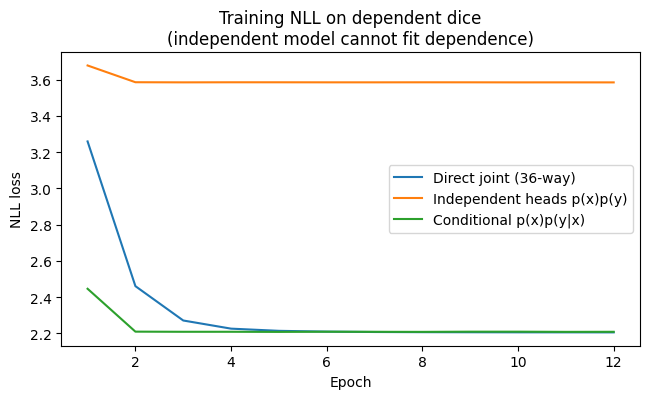

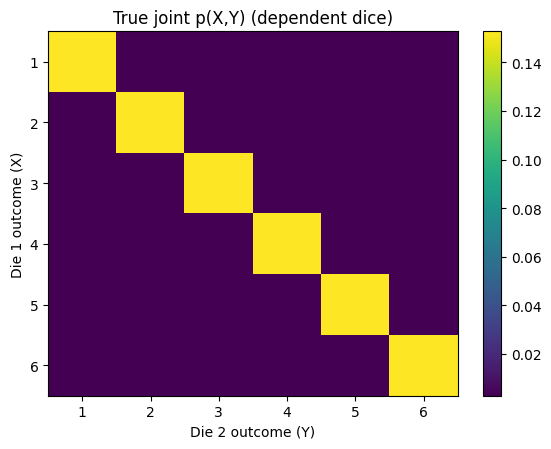

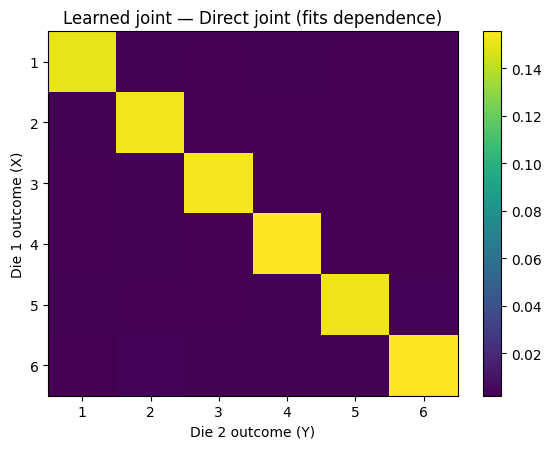

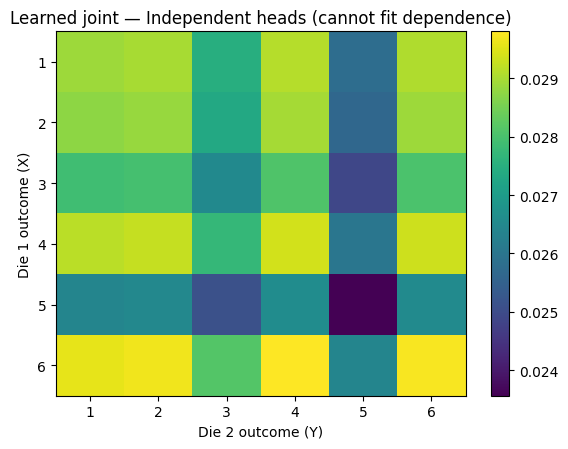

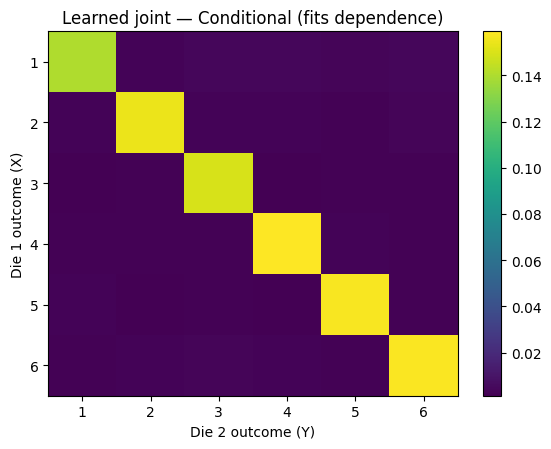

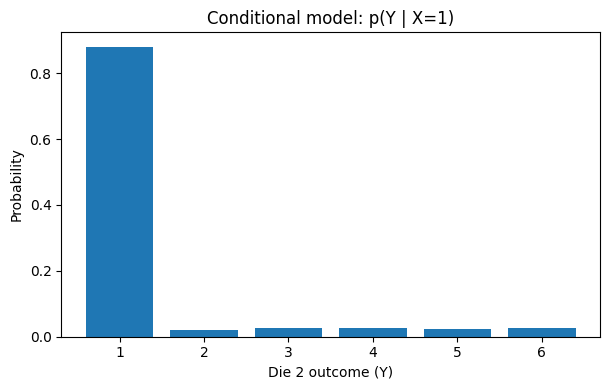

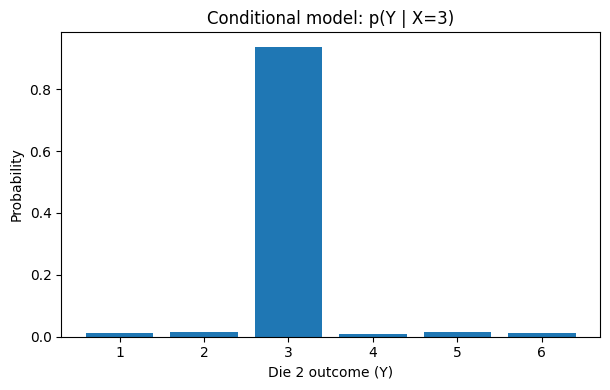

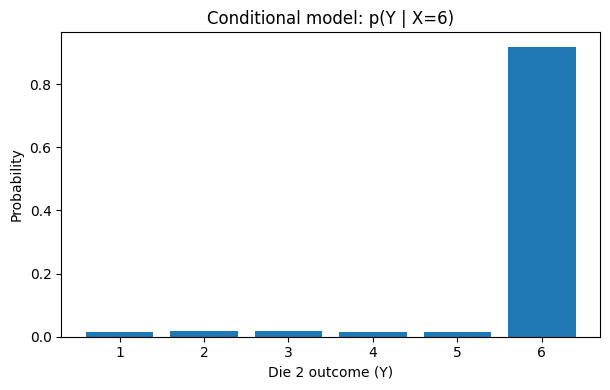

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# -----------------------------
# Repro
# -----------------------------
torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Dependent dice generator
# X ~ Uniform{1..6}
# Y = X with prob p_same, else Y ~ Uniform{1..6}
# This creates strong dependence/correlation.
# -----------------------------
def generate_dependent_dice(num_samples: int, p_same: float = 0.9):
    x = np.random.randint(1, 7, size=num_samples)              # 1..6
    y = np.random.randint(1, 7, size=num_samples)              # 1..6
    mask = (np.random.rand(num_samples) < p_same)
    y[mask] = x[mask]

    X_dummy = torch.ones(num_samples, 1, dtype=torch.float32)

    y_joint = torch.tensor((x - 1) * 6 + (y - 1), dtype=torch.long)  # 0..35
    y_x = torch.tensor(x - 1, dtype=torch.long)                      # 0..5
    y_y = torch.tensor(y - 1, dtype=torch.long)                      # 0..5
    return X_dummy, y_joint, y_x, y_y

def true_joint_table(p_same: float):
    # p(x)=1/6
    # p(y|x)=p_same + (1-p_same)/6 if y=x else (1-p_same)/6
    pj = torch.zeros(6, 6)
    for xi in range(6):
        for yi in range(6):
            py_given = (p_same + (1 - p_same)/6.0) if (yi == xi) else ((1 - p_same)/6.0)
            pj[xi, yi] = (1.0/6.0) * py_given
    return pj

# -----------------------------
# Data + loaders
# -----------------------------
P_SAME = 0.9
NUM_SAMPLES = 30_000       # keep small so it runs fast
BATCH_SIZE  = 512
EPOCHS      = 12
LR          = 1e-2

X, y_joint, y_x, y_y = generate_dependent_dice(NUM_SAMPLES, p_same=P_SAME)
loader_joint = DataLoader(TensorDataset(X, y_joint), batch_size=BATCH_SIZE, shuffle=True)
loader_xy    = DataLoader(TensorDataset(X, y_x, y_y), batch_size=BATCH_SIZE, shuffle=True)

true_joint = true_joint_table(P_SAME)

# -----------------------------
# Model A: Direct joint p(x,y) as 36-way softmax
# Universal for 2 discrete variables.
# -----------------------------
class DirectJoint(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(1, 36)

    def forward(self, x):
        return self.fc(x)  # [B,36]

    @torch.no_grad()
    def joint_table(self):
        logits = self(torch.ones(1,1, device=device)).squeeze(0)
        return torch.softmax(logits, dim=-1).view(6,6).cpu()

# -----------------------------
# Model B: Independent heads p(x)p(y)
# NOT universal: cannot represent dependence.
# -----------------------------
class IndependentHeads(nn.Module):
    def __init__(self):
        super().__init__()
        self.fx = nn.Linear(1, 6)
        self.fy = nn.Linear(1, 6)

    def forward(self, x):
        return self.fx(x), self.fy(x)

    @torch.no_grad()
    def joint_table(self):
        x = torch.ones(1,1, device=device)
        lx, ly = self(x)
        px = torch.softmax(lx.squeeze(0), dim=-1).cpu()
        py = torch.softmax(ly.squeeze(0), dim=-1).cpu()
        return (px[:,None] * py[None,:]), px, py

# -----------------------------
# Model C: Conditional factorization p(x)p(y|x)
# Universal for 2 discrete variables (same expressiveness as direct joint).
# -----------------------------
class Conditional(nn.Module):
    def __init__(self, emb_dim=8, hid=32):
        super().__init__()
        self.fx = nn.Linear(1, 6)           # p(x)
        self.xemb = nn.Embedding(6, emb_dim)
        self.fy = nn.Sequential(            # p(y|x)
            nn.Linear(1 + emb_dim, hid),
            nn.ReLU(),
            nn.Linear(hid, 6),
        )

    def forward(self, x, x_idx=None):
        lx = self.fx(x)                     # [B,6]
        if x_idx is None:
            x_idx = lx.argmax(dim=-1)       # inference
        e = self.xemb(x_idx)
        ly = self.fy(torch.cat([x, e], dim=-1))
        return lx, ly

    @torch.no_grad()
    def joint_table(self):
        x = torch.ones(1,1, device=device)
        lx, _ = self.forward(x, x_idx=torch.zeros(1, dtype=torch.long, device=device))
        px = torch.softmax(lx.squeeze(0), dim=-1).cpu()

        rows = []
        for i in range(6):
            _, ly = self.forward(x, x_idx=torch.tensor([i], dtype=torch.long, device=device))
            rows.append(torch.softmax(ly.squeeze(0), dim=-1).cpu())
        py_given_x = torch.stack(rows, dim=0)           # [6,6]
        joint = px[:,None] * py_given_x
        return joint, px, py_given_x

# -----------------------------
# Training helpers
# -----------------------------
def train_direct():
    m = DirectJoint().to(device)
    opt = optim.Adam(m.parameters(), lr=LR)
    crit = nn.CrossEntropyLoss()
    losses = []
    for _ in range(EPOCHS):
        m.train()
        tot, n = 0.0, 0
        for xb, yb in loader_joint:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(m(xb), yb)
            loss.backward()
            opt.step()
            tot += loss.item() * xb.size(0)
            n += xb.size(0)
        losses.append(tot/n)
    return m, losses

def train_independent():
    m = IndependentHeads().to(device)
    opt = optim.Adam(m.parameters(), lr=LR)
    crit = nn.CrossEntropyLoss()
    losses = []
    for _ in range(EPOCHS):
        m.train()
        tot, n = 0.0, 0
        for xb, xx, yy in loader_xy:
            xb, xx, yy = xb.to(device), xx.to(device), yy.to(device)
            opt.zero_grad()
            lx, ly = m(xb)
            loss = crit(lx, xx) + crit(ly, yy)
            loss.backward()
            opt.step()
            tot += loss.item() * xb.size(0)
            n += xb.size(0)
        losses.append(tot/n)
    return m, losses

def train_conditional():
    m = Conditional().to(device)
    opt = optim.Adam(m.parameters(), lr=LR)
    crit = nn.CrossEntropyLoss()
    losses = []
    for _ in range(EPOCHS):
        m.train()
        tot, n = 0.0, 0
        for xb, xx, yy in loader_xy:
            xb, xx, yy = xb.to(device), xx.to(device), yy.to(device)
            opt.zero_grad()
            lx, ly = m(xb, x_idx=xx)            # teacher forcing
            loss = crit(lx, xx) + crit(ly, yy)
            loss.backward()
            opt.step()
            tot += loss.item() * xb.size(0)
            n += xb.size(0)
        losses.append(tot/n)
    return m, losses

# -----------------------------
# Train all 3
# -----------------------------
mA, L_A = train_direct()
mB, L_B = train_independent()
mC, L_C = train_conditional()

with torch.no_grad():
    pj_A = mA.joint_table()
    pj_B, px_B, py_B = mB.joint_table()
    pj_C, px_C, pyx_C = mC.joint_table()

def kl(p, q, eps=1e-12):
    p = torch.clamp(p, eps, 1.0)
    q = torch.clamp(q, eps, 1.0)
    return (p * (p.log() - q.log())).sum().item()

print("Dependent dice setting: P(Y=X) =", P_SAME)
print("Final NLL losses:",
      {"DirectJoint": L_A[-1], "IndependentHeads": L_B[-1], "Conditional": L_C[-1]})
print("KL(true || learned):",
      {"DirectJoint": kl(true_joint, pj_A), "IndependentHeads": kl(true_joint, pj_B), "Conditional": kl(true_joint, pj_C)})

# -----------------------------
# Plots (one figure each)
# -----------------------------
def plot_loss(curves, labels, title):
    plt.figure(figsize=(6.6, 4.1))
    for c, lab in zip(curves, labels):
        plt.plot(np.arange(1, len(c)+1), c, label=lab)
    plt.xlabel("Epoch")
    plt.ylabel("NLL loss")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_heatmap(mat, title):
    plt.figure(figsize=(5.8, 4.6))
    plt.imshow(mat.numpy(), aspect="auto")
    plt.colorbar()
    plt.xticks(range(6), [str(i) for i in range(1,7)])
    plt.yticks(range(6), [str(i) for i in range(1,7)])
    plt.xlabel("Die 2 outcome (Y)")
    plt.ylabel("Die 1 outcome (X)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_bar(p, title, xlabel):
    plt.figure(figsize=(6.2, 4.0))
    plt.bar(range(1,7), p.numpy())
    plt.xticks(range(1,7))
    plt.xlabel(xlabel)
    plt.ylabel("Probability")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_loss([L_A, L_B, L_C],
          ["Direct joint (36-way)", "Independent heads p(x)p(y)", "Conditional p(x)p(y|x)"],
          "Training NLL on dependent dice\n(independent model cannot fit dependence)")

plot_heatmap(true_joint, "True joint p(X,Y) (dependent dice)")
plot_heatmap(pj_A, "Learned joint — Direct joint (fits dependence)")
plot_heatmap(pj_B, "Learned joint — Independent heads (cannot fit dependence)")
plot_heatmap(pj_C, "Learned joint — Conditional (fits dependence)")

# Show a few conditionals p(Y|X=x) from the conditional model (should peak on the diagonal)
for x in [0, 2, 5]:  # X=1,3,6
    plot_bar(pyx_C[x], f"Conditional model: p(Y | X={x+1})", "Die 2 outcome (Y)")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AutoregressiveDrivingPolicy(nn.Module):
    """
    p(steer, accel | state) = p(steer | state) * p(accel | state, steer)

    steer:   discrete in {0, ..., n_steer-1}
    accel:   discrete in {0, ..., n_accel-1}
    state:   continuous vector (features from sensors / perception stack)
    """
    def __init__(
        self,
        state_dim: int,
        n_steer: int,
        n_accel: int,
        hidden_dim: int = 256,
        steer_emb_dim: int = 32,
    ):
        super().__init__()
        self.n_steer = n_steer
        self.n_accel = n_accel

        # Shared state encoder
        self.state_net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # Head for p(steer | state)
        self.steer_head = nn.Linear(hidden_dim, n_steer)

        # Embedding for chosen steering bin
        self.steer_emb = nn.Embedding(n_steer, steer_emb_dim)

        # Network for p(accel | state, steer)
        self.accel_net = nn.Sequential(
            nn.Linear(hidden_dim + steer_emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        self.accel_head = nn.Linear(hidden_dim, n_accel)

    def forward(self, state, steer_idx=None, accel_idx=None):
        """
        If steer_idx & accel_idx are provided (training):
            returns dict with logits and total cross-entropy loss.
        If they are None (inference):
            returns only logits for both conditionals.
        """
        # Encode state
        h = self.state_net(state)  # [B, H]

        # ---- p(steer | state) ----
        logits_steer = self.steer_head(h)  # [B, n_steer]

        out = {"logits_steer": logits_steer}

        if steer_idx is not None:
            # Teacher forcing: use ground-truth steering to condition accel
            # steer_idx: [B] long
            steer_emb = self.steer_emb(steer_idx)  # [B, E]
        else:
            # For inference, you might want the most likely or sampled steer
            probs_steer = F.softmax(logits_steer, dim=-1)  # [B, n_steer]
            sampled_steer_idx = torch.multinomial(probs_steer, num_samples=1).squeeze(-1)
            steer_emb = self.steer_emb(sampled_steer_idx)
            out["sampled_steer_idx"] = sampled_steer_idx

        # ---- p(accel | state, steer) ----
        h_accel = self.accel_net(torch.cat([h, steer_emb], dim=-1))
        logits_accel = self.accel_head(h_accel)  # [B, n_accel]
        out["logits_accel"] = logits_accel

        # Loss if ground-truth indices given
        if (steer_idx is not None) and (accel_idx is not None):
            loss_steer = F.cross_entropy(logits_steer, steer_idx)
            loss_accel = F.cross_entropy(logits_accel, accel_idx)
            out["loss_steer"] = loss_steer
            out["loss_accel"] = loss_accel
            out["loss"] = loss_steer + loss_accel

        return out

    @torch.no_grad()
    def sample(self, state, greedy: bool = False):
        """
        Sample (steer, accel) ~ p(steer, accel | state)
        """
        h = self.state_net(state)

        # p(steer | state)
        logits_steer = self.steer_head(h)
        if greedy:
            steer_idx = logits_steer.argmax(dim=-1)
        else:
            probs_steer = F.softmax(logits_steer, dim=-1)
            steer_idx = torch.multinomial(probs_steer, num_samples=1).squeeze(-1)

        steer_emb = self.steer_emb(steer_idx)

        # p(accel | state, steer)
        h_accel = self.accel_net(torch.cat([h, steer_emb], dim=-1))
        logits_accel = self.accel_head(h_accel)
        if greedy:
            accel_idx = logits_accel.argmax(dim=-1)
        else:
            probs_accel = F.softmax(logits_accel, dim=-1)
            accel_idx = torch.multinomial(probs_accel, num_samples=1).squeeze(-1)

        return steer_idx, accel_idx

In [ ]:
import os
from dataclasses import dataclass
from typing import Dict, Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt


# -----------------------------
# 1) Autoregressive policy model
# -----------------------------
class AutoregressiveDrivingPolicy(nn.Module):
    """
    p(steer, accel | state) = p(steer | state) * p(accel | state, steer)

    steer_idx: discrete in {0..n_steer-1}
    accel_idx: discrete in {0..n_accel-1}
    state: float features (e.g., perception stack output)
    """
    def __init__(
        self,
        state_dim: int,
        n_steer: int,
        n_accel: int,
        hidden_dim: int = 256,
        steer_emb_dim: int = 32,
    ):
        super().__init__()
        self.n_steer = n_steer
        self.n_accel = n_accel

        self.state_net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        self.steer_head = nn.Linear(hidden_dim, n_steer)
        self.steer_emb = nn.Embedding(n_steer, steer_emb_dim)

        self.accel_net = nn.Sequential(
            nn.Linear(hidden_dim + steer_emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.accel_head = nn.Linear(hidden_dim, n_accel)

    def forward(self, state: torch.Tensor, steer_idx: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Teacher-forced forward: accel is conditioned on provided steer_idx.
        """
        h = self.state_net(state)
        logits_steer = self.steer_head(h)
        steer_emb = self.steer_emb(steer_idx)
        h2 = self.accel_net(torch.cat([h, steer_emb], dim=-1))
        logits_accel = self.accel_head(h2)
        return {"logits_steer": logits_steer, "logits_accel": logits_accel}

    @torch.no_grad()
    def sample(self, state: torch.Tensor, greedy: bool = False) -> Tuple[torch.Tensor, torch.Tensor, Dict[str, torch.Tensor]]:
        """
        Sample autoregressively:
          steer ~ p(steer|s)
          accel ~ p(accel|s, steer)
        Also returns logits for logging if needed.
        """
        h = self.state_net(state)
        logits_steer = self.steer_head(h)

        if greedy:
            steer_idx = logits_steer.argmax(dim=-1)
        else:
            probs_steer = F.softmax(logits_steer, dim=-1)
            steer_idx = torch.multinomial(probs_steer, num_samples=1).squeeze(-1)

        steer_emb = self.steer_emb(steer_idx)
        h2 = self.accel_net(torch.cat([h, steer_emb], dim=-1))
        logits_accel = self.accel_head(h2)

        if greedy:
            accel_idx = logits_accel.argmax(dim=-1)
        else:
            probs_accel = F.softmax(logits_accel, dim=-1)
            accel_idx = torch.multinomial(probs_accel, num_samples=1).squeeze(-1)

        aux = {"logits_steer": logits_steer, "logits_accel": logits_accel}
        return steer_idx, accel_idx, aux


# ---------------------------------------
# 2) Demo manifold distance (Mahalanobis)
# ---------------------------------------
class DemoManifoldDistance:
    """
    Fit Gaussian stats (mean, covariance) on demo state features.
    Distance = sqrt((x-mu)^T Sigma^{-1} (x-mu))  (Mahalanobis)
    """

    def __init__(self, eps: float = 1e-4):
        self.eps = eps
        self.mu: Optional[torch.Tensor] = None
        self.inv_cov: Optional[torch.Tensor] = None

    def fit(self, demo_states: torch.Tensor):
        """
        demo_states: [N, D]
        """
        assert demo_states.dim() == 2
        mu = demo_states.mean(dim=0)  # [D]
        x = demo_states - mu
        # Cov: [D, D]
        cov = (x.t() @ x) / max(demo_states.shape[0] - 1, 1)
        # Stabilize
        cov = cov + self.eps * torch.eye(cov.shape[0], device=cov.device, dtype=cov.dtype)

        inv_cov = torch.linalg.inv(cov)

        self.mu = mu
        self.inv_cov = inv_cov

    def distance(self, states: torch.Tensor) -> torch.Tensor:
        """
        states: [B, D]
        returns: [B] Mahalanobis distances
        """
        assert self.mu is not None and self.inv_cov is not None, "Call fit() first."
        x = states - self.mu
        # d^2 = x^T inv_cov x for each batch item
        # Efficient batch: (x @ inv_cov) * x then sum over dim
        d2 = (x @ self.inv_cov * x).sum(dim=-1)
        return torch.sqrt(torch.clamp(d2, min=0.0))


# -----------------------------------------
# 3) AR log-likelihood for (steer, accel)
# -----------------------------------------
def ar_logprob_from_logits(
    logits_steer: torch.Tensor,
    logits_accel: torch.Tensor,
    steer_idx: torch.Tensor,
    accel_idx: torch.Tensor,
) -> torch.Tensor:
    """
    logits_*: [B, K]
    idx: [B]
    Returns per-sample log p(steer, accel | s) = log p(steer|s) + log p(accel|s,steer)
    """
    logp_steer = F.log_softmax(logits_steer, dim=-1).gather(1, steer_idx[:, None]).squeeze(1)
    logp_accel = F.log_softmax(logits_accel, dim=-1).gather(1, accel_idx[:, None]).squeeze(1)
    return logp_steer + logp_accel


# -----------------------------------------
# 4) Simple logger + plotting utilities
# -----------------------------------------
@dataclass
class LoggedSeries:
    demo_dist: np.ndarray          # [T]
    ar_logp: np.ndarray            # [T]
    ar_logp_cum: np.ndarray        # [T]
    demo_dist_trend: np.ndarray    # [T]
    ar_logp_trend: np.ndarray      # [T]
    ar_logp_cum_trend: np.ndarray  # [T]


def moving_average(x: np.ndarray, window: int) -> np.ndarray:
    if window <= 1:
        return x.copy()
    kernel = np.ones(window, dtype=np.float64) / float(window)
    return np.convolve(x, kernel, mode="same")


def make_three_plots(series: LoggedSeries, out_dir: str, window: int) -> Dict[str, str]:
    os.makedirs(out_dir, exist_ok=True)
    t = np.arange(series.demo_dist.shape[0])

    # Plot 1
    plt.figure(figsize=(10, 4))
    plt.plot(t, series.demo_dist, label="Demo manifold distance (per step)")
    plt.plot(t, series.demo_dist_trend, label=f"Trend (moving avg, window={window})")
    plt.xlabel("Time step")
    plt.ylabel("Distance (Mahalanobis)")
    plt.title("Demo Manifold Distance: Level and Trend")
    plt.legend()
    plt.tight_layout()
    p1 = os.path.join(out_dir, "demo_manifold_distance.png")
    plt.savefig(p1, dpi=150)
    plt.close()

    # Plot 2
    plt.figure(figsize=(10, 4))
    plt.plot(t, series.ar_logp, label="AR log-likelihood (per step)")
    plt.plot(t, series.ar_logp_trend, label=f"Trend (moving avg, window={window})")
    plt.xlabel("Time step")
    plt.ylabel("Log-likelihood")
    plt.title("Autoregressive Likelihood: Per-step Decay and Trend")
    plt.legend()
    plt.tight_layout()
    p2 = os.path.join(out_dir, "ar_loglik_per_step.png")
    plt.savefig(p2, dpi=150)
    plt.close()

    # Plot 3
    plt.figure(figsize=(10, 4))
    plt.plot(t, series.ar_logp_cum, label="Cumulative AR log-likelihood")
    plt.plot(t, series.ar_logp_cum_trend, label=f"Trend (moving avg, window={window})")
    plt.xlabel("Time step")
    plt.ylabel("Cumulative log-likelihood")
    plt.title("Autoregressive Likelihood: Cumulative Drift Signal")
    plt.legend()
    plt.tight_layout()
    p3 = os.path.join(out_dir, "ar_loglik_cumulative.png")
    plt.savefig(p3, dpi=150)
    plt.close()

    return {"plot1": p1, "plot2": p2, "plot3": p3}


# -----------------------------------------
# 5) Example data generation (replace this)
# -----------------------------------------
def generate_synthetic_rollout(
    T: int,
    state_dim: int,
    n_steer: int,
    n_accel: int,
    drift_start: int = 90,
    device: str = "cpu",
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Produces a synthetic rollout with a distribution drift in states after drift_start.
    Returns:
      states: [T, D]
      steer_idx: [T]
      accel_idx: [T]
    """
    rng = torch.Generator(device=device)
    rng.manual_seed(123)

    # States: pre-drift ~ N(0, I), post-drift shifts mean and covariance a bit
    states = torch.randn(T, state_dim, generator=rng, device=device)
    shift = torch.zeros(state_dim, device=device)
    shift[: min(8, state_dim)] = 1.5  # drift direction
    for t in range(T):
        if t >= drift_start:
            states[t] = 1.0 * states[t] + shift + 0.25 * torch.randn(state_dim, generator=rng, device=device)

    # Demonstrator actions (simple synthetic mapping)
    # steer depends on first feature; accel depends on second feature and steer
    steer_cont = torch.tanh(states[:, 0])  # [-1, 1]
    steer_idx = torch.clamp(((steer_cont + 1) * 0.5 * (n_steer - 1)).round().long(), 0, n_steer - 1)

    accel_cont = torch.tanh(states[:, 1] - 0.3 * (steer_cont))  # [-1, 1]
    accel_idx = torch.clamp(((accel_cont + 1) * 0.5 * (n_accel - 1)).round().long(), 0, n_accel - 1)

    return states, steer_idx, accel_idx


# -----------------------------------------
# 6) Main: fit demo stats, run rollout, log
# -----------------------------------------
def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Discretization choices
    state_dim = 64
    n_steer = 21
    n_accel = 11

    # Logging / plotting
    T = 200
    ma_window = 15
    out_dir = "./logs_ar_demo"

    # Model (random init for demo; in real life load trained weights)
    model = AutoregressiveDrivingPolicy(state_dim, n_steer, n_accel).to(device)
    model.eval()

    # --- "Demonstration dataset" states to define manifold ---
    # In practice: sample many states from your logged demos.
    demo_states = torch.randn(5000, state_dim, device=device)
    demo_stats = DemoManifoldDistance(eps=1e-3)
    demo_stats.fit(demo_states)

    # --- Rollout data (replace with your real rollout) ---
    states, demo_steer, demo_accel = generate_synthetic_rollout(
        T=T, state_dim=state_dim, n_steer=n_steer, n_accel=n_accel, drift_start=90, device=device
    )

    # --- Log arrays ---
    demo_dist_list = []
    ar_logp_list = []

    # Here we compute likelihood under the model of the *demonstrator actions*
    # (teacher-forced), which is a common drift / compounding-risk signal.
    with torch.no_grad():
        for t in range(T):
            s = states[t : t + 1]                 # [1, D]
            steer_t = demo_steer[t : t + 1]       # [1]
            accel_t = demo_accel[t : t + 1]       # [1]

            # 1) Demo manifold distance
            d = demo_stats.distance(s).item()
            demo_dist_list.append(d)

            # 2) AR per-step log-likelihood of demo action
            out = model(s, steer_idx=steer_t)
            logp = ar_logprob_from_logits(out["logits_steer"], out["logits_accel"], steer_t, accel_t).item()
            ar_logp_list.append(logp)

    demo_dist = np.asarray(demo_dist_list, dtype=np.float64)
    ar_logp = np.asarray(ar_logp_list, dtype=np.float64)
    ar_logp_cum = np.cumsum(ar_logp)

    # Trends
    demo_dist_trend = moving_average(demo_dist, ma_window)
    ar_logp_trend = moving_average(ar_logp, ma_window)
    ar_logp_cum_trend = moving_average(ar_logp_cum, ma_window)

    series = LoggedSeries(
        demo_dist=demo_dist,
        ar_logp=ar_logp,
        ar_logp_cum=ar_logp_cum,
        demo_dist_trend=demo_dist_trend,
        ar_logp_trend=ar_logp_trend,
        ar_logp_cum_trend=ar_logp_cum_trend,
    )

    paths = make_three_plots(series, out_dir=out_dir, window=ma_window)

    print("Saved plots:")
    for k, v in paths.items():
        print(f"  {k}: {os.path.abspath(v)}")

    # Optional: TensorBoard logging of the figures
    # pip install tensorboard
    try:
        from torch.utils.tensorboard import SummaryWriter
        writer = SummaryWriter(log_dir=os.path.join(out_dir, "tb"))

        # Load images and log as figures (simple approach: re-create figures inline)
        # We'll log the PNGs as images.
        import matplotlib.image as mpimg

        for tag, p in [
            ("demo_manifold_distance", paths["plot1"]),
            ("ar_loglik_per_step", paths["plot2"]),
            ("ar_loglik_cumulative", paths["plot3"]),
        ]:
            img = mpimg.imread(p)
            # HWC -> CHW
            if img.ndim == 2:
                img = img[..., None]
            img_chw = np.transpose(img, (2, 0, 1))
            writer.add_image(tag, img_chw, global_step=0)

        writer.close()
        print(f"TensorBoard logs written to: {os.path.abspath(os.path.join(out_dir, 'tb'))}")
        print("Run: tensorboard --logdir ./logs_ar_demo/tb")
    except Exception as e:
        print(f"(TensorBoard logging skipped: {e})")


if __name__ == "__main__":
    main()

Saved plots:
  plot1: /content/logs_ar_demo/demo_manifold_distance.png
  plot2: /content/logs_ar_demo/ar_loglik_per_step.png
  plot3: /content/logs_ar_demo/ar_loglik_cumulative.png
TensorBoard logs written to: /content/logs_ar_demo/tb
Run: tensorboard --logdir ./logs_ar_demo/tb


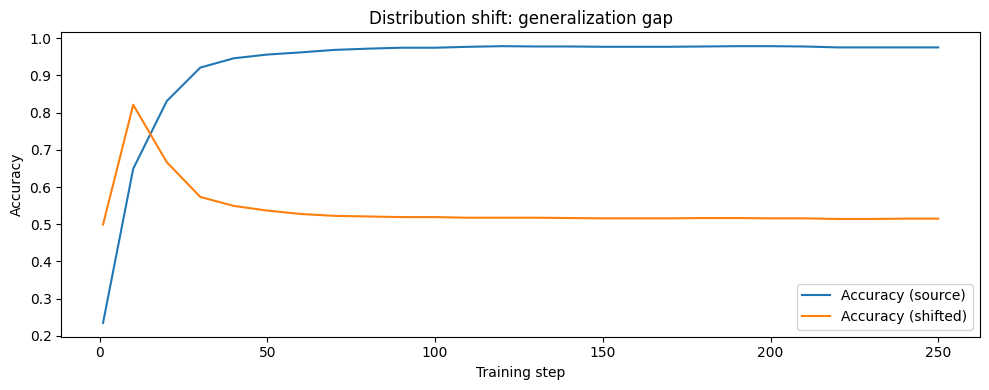

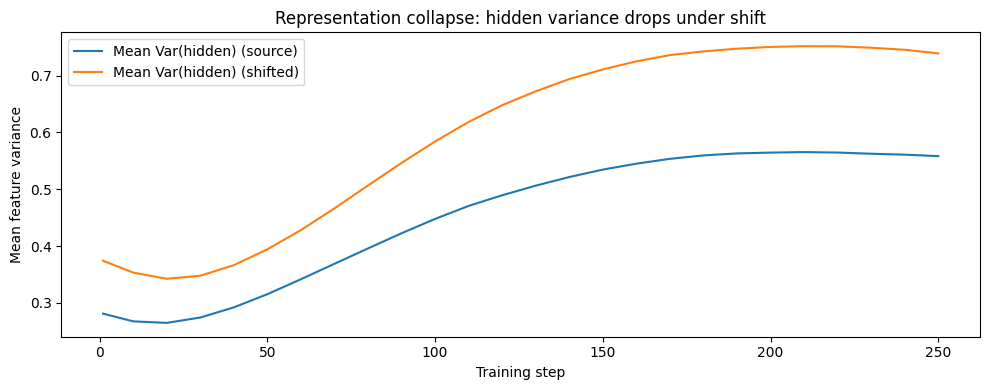

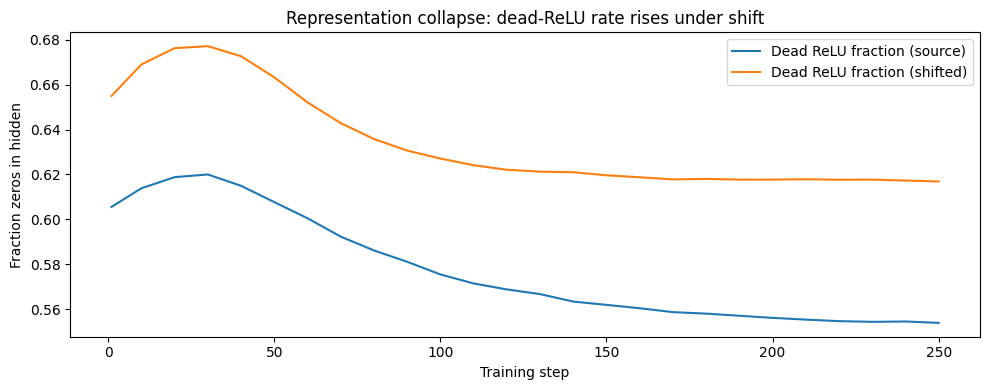

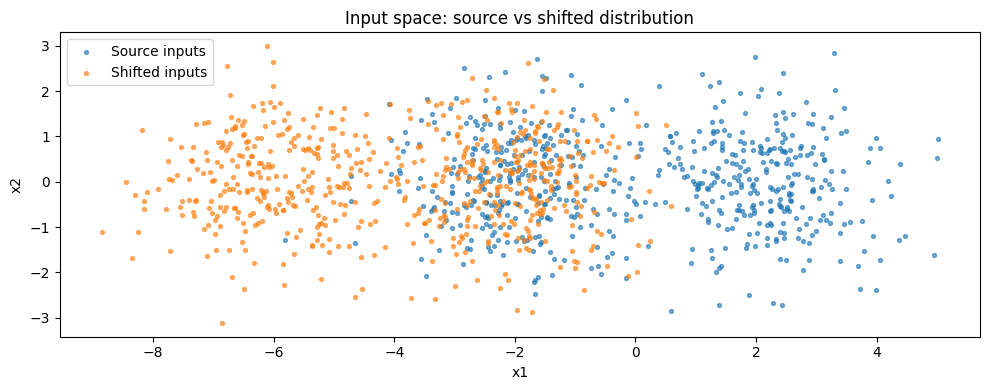

Final (source) loss, acc, var(h), frac_zero: (0.06861918419599533, 0.9750000238418579, 0.5582362413406372, 0.5539583563804626)
Final (shift ) loss, acc, var(h), frac_zero: (2.541240930557251, 0.5149999856948853, 0.7389782667160034, 0.6168749928474426)


In [ ]:
# Colab cell: distribution shift + representation collapse in 2-layer MLP
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------
# 1) Synthetic data
# -------------------------
def make_gaussian_classification(n: int, mean0, mean1, cov_scale=1.0):
    n0 = n // 2
    n1 = n - n0
    X0 = torch.randn(n0, 2) * cov_scale + torch.tensor(mean0)
    X1 = torch.randn(n1, 2) * cov_scale + torch.tensor(mean1)
    X = torch.cat([X0, X1], dim=0)
    y = torch.cat([torch.zeros(n0, dtype=torch.long), torch.ones(n1, dtype=torch.long)], dim=0)
    idx = torch.randperm(n)
    return X[idx], y[idx]

# Source distribution: separable by x1
mean0_src = [-2.0, 0.0]
mean1_src = [ 2.0, 0.0]

# Shifted distribution: same separation but *global left shift* in x1
# This often makes ReLU gates flip off (dead) if the network learned a positive-x1 regime.
shift = [-4.0, 0.0]
mean0_sh = [mean0_src[0] + shift[0], mean0_src[1] + shift[1]]
mean1_sh = [mean1_src[0] + shift[0], mean1_src[1] + shift[1]]

N_train, N_eval = 4000, 1200
X_train, y_train = make_gaussian_classification(N_train, mean0_src, mean1_src)
X_src, y_src     = make_gaussian_classification(N_eval,  mean0_src, mean1_src)
X_sh,  y_sh      = make_gaussian_classification(N_eval,  mean0_sh,  mean1_sh)

X_train, y_train = X_train.to(device), y_train.to(device)
X_src, y_src     = X_src.to(device),   y_src.to(device)
X_sh,  y_sh      = X_sh.to(device),    y_sh.to(device)

# -------------------------
# 2) 2-layer MLP
# -------------------------
class TwoLayerMLP(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2)

    def forward(self, x, return_rep=False):
        z1 = self.fc1(x)      # pre-activation
        h1 = F.relu(z1)       # hidden representation
        logits = self.fc2(h1)
        if return_rep:
            return logits, z1, h1
        return logits

model = TwoLayerMLP(hidden_dim=16).to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-2)  # mild WD helps collapse show up

@torch.no_grad()
def metrics(X, y):
    logits, z1, h1 = model(X, return_rep=True)
    loss = F.cross_entropy(logits, y).item()
    acc  = (logits.argmax(dim=-1) == y).float().mean().item()

    # Collapse indicators on hidden h1
    mean_feat_var = h1.var(dim=0, unbiased=False).mean().item()
    frac_zero     = (h1 == 0).float().mean().item()  # dead ReLU fraction

    return loss, acc, mean_feat_var, frac_zero

# -------------------------
# 3) Train + log
# -------------------------
steps, batch_size, log_every = 250, 256, 10
hist = {"step": [], "src_acc": [], "sh_acc": [], "src_var": [], "sh_var": [], "src_zero": [], "sh_zero": []}

for step in range(1, steps + 1):
    idx = torch.randint(0, X_train.shape[0], (batch_size,), device=device)
    xb, yb = X_train[idx], y_train[idx]

    loss = F.cross_entropy(model(xb), yb)
    opt.zero_grad()
    loss.backward()
    opt.step()

    if step % log_every == 0 or step == 1:
        _, src_acc, src_var, src_zero = metrics(X_src, y_src)
        _, sh_acc,  sh_var,  sh_zero  = metrics(X_sh,  y_sh)
        hist["step"].append(step)
        hist["src_acc"].append(src_acc);   hist["sh_acc"].append(sh_acc)
        hist["src_var"].append(src_var);   hist["sh_var"].append(sh_var)
        hist["src_zero"].append(src_zero); hist["sh_zero"].append(sh_zero)

t = np.array(hist["step"])

# -------------------------
# 4) Plots
# -------------------------
plt.figure(figsize=(10,4))
plt.plot(t, hist["src_acc"], label="Accuracy (source)")
plt.plot(t, hist["sh_acc"],  label="Accuracy (shifted)")
plt.xlabel("Training step"); plt.ylabel("Accuracy")
plt.title("Distribution shift: generalization gap")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(t, hist["src_var"], label="Mean Var(hidden) (source)")
plt.plot(t, hist["sh_var"],  label="Mean Var(hidden) (shifted)")
plt.xlabel("Training step"); plt.ylabel("Mean feature variance")
plt.title("Representation collapse: hidden variance drops under shift")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(t, hist["src_zero"], label="Dead ReLU fraction (source)")
plt.plot(t, hist["sh_zero"],  label="Dead ReLU fraction (shifted)")
plt.xlabel("Training step"); plt.ylabel("Fraction zeros in hidden")
plt.title("Representation collapse: dead-ReLU rate rises under shift")
plt.legend(); plt.tight_layout(); plt.show()

# Visualize the shift in input space
n_show = 600
xs_src = X_src[:n_show].detach().cpu()
xs_sh  = X_sh[:n_show].detach().cpu()

plt.figure(figsize=(10,4))
plt.scatter(xs_src[:,0], xs_src[:,1], s=8, alpha=0.6, label="Source inputs")
plt.scatter(xs_sh[:,0],  xs_sh[:,1],  s=8, alpha=0.6, label="Shifted inputs")
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("Input space: source vs shifted distribution")
plt.legend(); plt.tight_layout(); plt.show()

print("Final (source) loss, acc, var(h), frac_zero:", metrics(X_src, y_src))
print("Final (shift ) loss, acc, var(h), frac_zero:", metrics(X_sh,  y_sh))

In [ ]:
import torch
y=torch.softmax(torch.tensor([1,1,1,1,1,1],dtype=torch.float), dim=0)
labels=[1,2,3,4,5,6]
#freq = [1,1,1,1,1,1]
print(f"prob of each die 1-6:{y}")


prob of each die 1-6:tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])


# **Lecture 3**

<h3>L3 covers first half of policy gradients</h3>

<ul>
<li>Goal: Maximixe the sum of expected rewards </li>
<li>$sumexpectedrewards = max_\theta \mathbb E_{\tau\sim p_\theta(\tau)}\mathbb \sum[r(s,a)]$</li>
<li>In practice this means from every state go into test mode and test finding a path to goal and sum all these trajectories for every possibl# PPO and e state and every possible action and find the set of (a,s) which maximizes the sum of rewards. Tedious if you can do so for an environment. For text envinronments the LLM can be an environment and the LLM can synthetically generate data. </li>
<li>$\theta$ is the parameters in the NN, $\tau$ are the trajectories</li>
<li>one way to do this is with imitaiton learning. The simplest form of IL is behavorial cloning</li>
<li>The problem with BC is you can never get higher performance than the expert. We can solve this later using FT. </li>
</ul>

# **Behavorial Cloning**

<ul>
<li>One core principle of Deep RL is to Convert the maximation of sum of rewards to the NLL to use NN optimization like SGD.</li>
<li> minimize the negative of the log likelihood $min_{\theta} -\mathbb E_{(s,a)\sim D}[log \pi_{\theta}(a|s)]$</li>
<li>$D$ are demonstrations, s are states, a are actions, $\pi$ is the policy represented by a neural net. p(a|s) is the conditional probability which is the distribution represented by the NN. </li>
<li>There are 2 cases, the continuous case and the discrete case. We covered the continuous case with an example from self driving cars. </li>
<li>Continuous: Gaussian prior or Multiple Gaussians. For a single gaussian $\pi_{theta}(a|s)= N(\mu, \sigma) and for a GMM, gaussian mixture model  $ </li>
<li>Gaussian Mixture Model: $\boxed{
\pi_\theta(a\mid s)
\;=\;
\sum_{k=1}^{K}
{\alpha_{\theta,k}(s)}
{N\!\left(a;\,\mu_{\theta,k}(s),\,\Sigma_{\theta,k}(s)\right)}_{\text{component }k}
}$</li>
<li>where alpha is the mixing weight; $\alpha_{\theta,k}(s) \ge 0$ and $\sum_{k=1}^K \alpha_{\theta,k}(s) = 1$</li>
<li>GMMs are fully differentiable for backprop derivations and can be trained by MLE, PPO, RLHF</li>

</ul>

In [ ]:


# PyTorch GMM (K=2) demo: MLE vs PPO vs RLHF(KL-to-ref)
# -----------------------------------------------------
# - 1D action a
# - Discrete state s in {0,1} (embedded)
# - GMM policy outputs:
#     pi(a|s) = sum_k w_k(s) * N(a; mu_k(s), sigma_k(s)^2)
#
# Versions:
#   (A) MLE: fit to expert samples from a known true GMM
#   (B) PPO: optimize a reward with two modes
#   (C) RLHF: optimize reward_model(a,s) - beta * KL(pi || pi_ref) via PPO-style update

import math, copy, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# True (expert) data generator
# -----------------------------
# Two states with different mixture params (weights, means, stds)
TRUE = {
    0: dict(w=np.array([0.70, 0.30]), mu=np.array([-2.0,  2.0]), sig=np.array([0.35, 0.80])),
    1: dict(w=np.array([0.30, 0.70]), mu=np.array([-1.0,  3.0]), sig=np.array([0.80, 0.45])),
}

def sample_true_gmm(s, n):
    p = TRUE[int(s)]
    ks = np.random.choice(2, size=n, p=p["w"])
    a  = np.random.randn(n) * p["sig"][ks] + p["mu"][ks]
    return a.astype(np.float32), ks.astype(np.int64)

def true_pdf(s, grid):
    p = TRUE[int(s)]
    # mixture pdf on grid
    pdf = np.zeros_like(grid, dtype=np.float64)
    for k in range(2):
        mu, sig, w = p["mu"][k], p["sig"][k], p["w"][k]
        pdf += w * (1.0/(np.sqrt(2*np.pi)*sig)) * np.exp(-0.5*((grid-mu)/sig)**2)
    return pdf

# -----------------------------
# GMM Policy (K=2), 1D action
# -----------------------------
class GMMPolicy(nn.Module):
    def __init__(self, n_states=2, emb_dim=8, hid=64, K=2):
        super().__init__()
        self.K = K
        self.emb = nn.Embedding(n_states, emb_dim)
        self.net = nn.Sequential(
            nn.Linear(emb_dim, hid),
            nn.Tanh(),
            nn.Linear(hid, hid),
            nn.Tanh(),
        )
        self.logits_head = nn.Linear(hid, K)   # mixture weights
        self.mu_head     = nn.Linear(hid, K)   # means
        self.logsig_head = nn.Linear(hid, K)   # log stds

    def forward(self, s_idx):
        # s_idx: [B] long
        h = self.net(self.emb(s_idx))
        logits = self.logits_head(h)          # [B,K]
        mu     = self.mu_head(h)              # [B,K]
        logsig = self.logsig_head(h).clamp(-5, 2)  # keep stable
        return logits, mu, logsig

    def log_prob(self, s_idx, a):
        # a: [B] float
        logits, mu, logsig = self.forward(s_idx)   # [B,K]
        w = torch.softmax(logits, dim=-1)          # [B,K]

        a_ = a.unsqueeze(-1)                        # [B,1]
        sig = logsig.exp()
        # log N(a | mu_k, sig_k)
        logN = -0.5 * (((a_ - mu)/sig)**2 + 2*logsig + math.log(2*math.pi))  # [B,K]
        # log sum_k w_k * exp(logN_k)
        logp = torch.logsumexp(torch.log(w + 1e-12) + logN, dim=-1)          # [B]
        return logp

    @torch.no_grad()
    def sample(self, s_idx):
        logits, mu, logsig = self.forward(s_idx)
        w = torch.softmax(logits, dim=-1)
        k = torch.multinomial(w, num_samples=1).squeeze(-1)  # [B]
        chosen_mu = mu.gather(1, k.unsqueeze(-1)).squeeze(-1)
        chosen_ls = logsig.gather(1, k.unsqueeze(-1)).squeeze(-1)
        a = chosen_mu + chosen_ls.exp() * torch.randn_like(chosen_mu)
        return a, k

def describe_policy(policy, title=""):
    policy.eval()
    out = {}
    for s in [0,1]:
        s_t = torch.tensor([s], dtype=torch.long, device=device)
        logits, mu, logsig = policy(s_t)
        w = torch.softmax(logits, dim=-1).detach().cpu().numpy().squeeze()
        mu = mu.detach().cpu().numpy().squeeze()
        sig = logsig.exp().detach().cpu().numpy().squeeze()
        out[s] = dict(w=w, mu=mu, sig=sig)
    print(title)
    for s in [0,1]:
        print(f" state {s}: w={out[s]['w']}, mu={out[s]['mu']}, sig={out[s]['sig']}")
    return out

# -----------------------------
# Data for MLE / BC
# -----------------------------
def make_expert_dataset(n_per_state=8000):
    S = []
    A = []
    for s in [0,1]:
        a, _ = sample_true_gmm(s, n_per_state)
        S.append(np.full((n_per_state,), s, dtype=np.int64))
        A.append(a)
    S = np.concatenate(S)
    A = np.concatenate(A)
    # shuffle
    idx = np.random.permutation(len(S))
    return torch.tensor(S[idx], dtype=torch.long), torch.tensor(A[idx], dtype=torch.float32)

S_exp, A_exp = make_expert_dataset()

# -----------------------------
# (A) MLE / Behavioral Cloning
# -----------------------------
def train_mle(policy, S, A, steps=2000, batch=512, lr=3e-3):
    policy.train()
    opt = torch.optim.Adam(policy.parameters(), lr=lr)
    losses = []
    for t in range(steps):
        idx = torch.randint(0, S.size(0), (batch,))
        s_b = S[idx].to(device)
        a_b = A[idx].to(device)
        logp = policy.log_prob(s_b, a_b)
        loss = (-logp).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss.item()))
    return np.array(losses)

# -----------------------------
# Toy RL environment / reward
# -----------------------------
# Two-mode reward: the "right" mode depends on state (like "turn-left vs turn-right")
# Reward = logsumexp of two quadratic peaks => multimodal optimum
def rl_reward(s, a):
    # s: [B] long, a: [B] float
    # state 0 prefers modes near -2 and +2
    # state 1 prefers modes near -1 and +3
    s0 = (s == 0)
    s1 = ~s0
    r = torch.empty_like(a)

    # mode centers and widths
    muL0, muR0 = -2.0,  2.0
    muL1, muR1 = -1.0,  3.0
    sigL, sigR = 0.6, 0.6

    # log mixture of two Gaussians as reward shape
    def logmix(a, mu1, mu2):
        l1 = -0.5*((a-mu1)/sigL)**2
        l2 = -0.5*((a-mu2)/sigR)**2
        return torch.logsumexp(torch.stack([l1, l2], dim=0), dim=0)

    r[s0] = logmix(a[s0], muL0, muR0)
    r[s1] = logmix(a[s1], muL1, muR1)
    return r

# -----------------------------
# Value baseline for PPO
# -----------------------------
class ValueNet(nn.Module):
    def __init__(self, n_states=2, emb_dim=8, hid=64):
        super().__init__()
        self.emb = nn.Embedding(n_states, emb_dim)
        self.net = nn.Sequential(
            nn.Linear(emb_dim, hid),
            nn.Tanh(),
            nn.Linear(hid, hid),
            nn.Tanh(),
            nn.Linear(hid, 1)
        )
    def forward(self, s):
        return self.net(self.emb(s)).squeeze(-1)

# -----------------------------
# PPO trainer (single-step episodic bandit)
# -----------------------------
def ppo_train(policy, reward_fn, steps=400, batch=2048, ppo_epochs=4,
              clip=0.2, lr_pi=3e-4, lr_v=1e-3, ent_coef=0.00):

    policy.train()
    vnet = ValueNet().to(device)
    opt_pi = torch.optim.Adam(policy.parameters(), lr=lr_pi)
    opt_v  = torch.optim.Adam(vnet.parameters(), lr=lr_v)

    avgR = []
    for it in range(steps):
        # sample states uniformly
        s = torch.randint(0, 2, (batch,), device=device, dtype=torch.long)

        with torch.no_grad():
            a, _ = policy.sample(s)
            logp_old = policy.log_prob(s, a)
            r = reward_fn(s, a)
            v = vnet(s)
            adv = (r - v)
            adv = (adv - adv.mean()) / (adv.std() + 1e-8)
            ret = r  # bandit return

        # PPO update epochs
        for _ in range(ppo_epochs):
            logp = policy.log_prob(s, a)
            ratio = torch.exp(logp - logp_old)
            unclipped = ratio * adv
            clipped = torch.clamp(ratio, 1-clip, 1+clip) * adv
            pi_loss = -(torch.min(unclipped, clipped)).mean()

            # optional entropy bonus (estimate via sampling component; cheap proxy: -E[logp])
            ent_bonus = -logp.mean()
            pi_loss = pi_loss - ent_coef * ent_bonus

            opt_pi.zero_grad()
            pi_loss.backward()
            opt_pi.step()

            # value update
            v_pred = vnet(s)
            v_loss = F.mse_loss(v_pred, ret)
            opt_v.zero_grad()
            v_loss.backward()
            opt_v.step()

        avgR.append(float(r.mean().item()))
    return np.array(avgR)

# -----------------------------
# RLHF-style: KL-penalized objective to a reference policy
# -----------------------------
# Objective: maximize E[ r_model(s,a) ] - beta * KL(pi || pi_ref)
# Using sample-level KL term: (logpi - logpref) as unbiased estimator under pi.
def rlhf_train(policy, ref_policy, reward_model_fn, beta=0.05,
               steps=400, batch=2048, ppo_epochs=4,
               clip=0.2, lr_pi=3e-4, lr_v=1e-3):

    policy.train()
    ref_policy.eval()
    vnet = ValueNet().to(device)
    opt_pi = torch.optim.Adam(policy.parameters(), lr=lr_pi)
    opt_v  = torch.optim.Adam(vnet.parameters(), lr=lr_v)

    avgR, avgKL = [], []
    for it in range(steps):
        s = torch.randint(0, 2, (batch,), device=device, dtype=torch.long)
        with torch.no_grad():
            a, _ = policy.sample(s)
            logp_old = policy.log_prob(s, a)
            logpref  = ref_policy.log_prob(s, a)
            r = reward_model_fn(s, a)
            kl_sample = (logp_old - logpref)  # sample estimator of KL direction
            shaped = r - beta * kl_sample
            v = vnet(s)
            adv = (shaped - v)
            adv = (adv - adv.mean()) / (adv.std() + 1e-8)
            ret = shaped

        for _ in range(ppo_epochs):
            logp = policy.log_prob(s, a)
            ratio = torch.exp(logp - logp_old)
            unclipped = ratio * adv
            clipped = torch.clamp(ratio, 1-clip, 1+clip) * adv
            pi_loss = -(torch.min(unclipped, clipped)).mean()

            opt_pi.zero_grad()
            pi_loss.backward()
            opt_pi.step()

            v_pred = vnet(s)
            v_loss = F.mse_loss(v_pred, ret)
            opt_v.zero_grad()
            v_loss.backward()
            opt_v.step()

        avgR.append(float(r.mean().item()))
        avgKL.append(float(kl_sample.mean().item()))
    return np.array(avgR), np.array(avgKL)

# Reward model for RLHF (toy): prefers slightly different targets than the true RL reward
# e.g., "helpful preference": prefer larger positive actions in state 1, moderate in state 0
def reward_model(s, a):
    s0 = (s == 0)
    s1 = ~s0
    r = torch.empty_like(a)
    # state 0: prefers near +1.5 (single preference peak)
    r[s0] = -0.5 * ((a[s0] - 1.5)/0.7)**2
    # state 1: prefers near +3.0 strongly
    r[s1] = -0.5 * ((a[s1] - 3.0)/0.5)**2
    return r

# -----------------------------
# Run all three versions
# -----------------------------
# A) MLE
pi_mle = GMMPolicy().to(device)
mle_loss = train_mle(pi_mle, S_exp, A_exp, steps=2000, batch=512, lr=3e-3)
mle_params = describe_policy(pi_mle, title="\nMLE learned params:")

# Freeze reference for RLHF as "pretrained base"
pi_ref = copy.deepcopy(pi_mle).to(device)
for p in pi_ref.parameters():
    p.requires_grad_(False)

# B) PPO from scratch
pi_ppo = GMMPolicy().to(device)
ppo_curve = ppo_train(pi_ppo, rl_reward, steps=350, batch=2048, ppo_epochs=4,
                      clip=0.2, lr_pi=3e-4, lr_v=1e-3, ent_coef=0.00)
ppo_params = describe_policy(pi_ppo, title="\nPPO learned params:")

# C) RLHF: start from ref (or scratch; here start near ref then adapt)
pi_rlhf = copy.deepcopy(pi_ref).to(device)
rlhf_curve, kl_curve = rlhf_train(pi_rlhf, pi_ref, reward_model, beta=0.08,
                                  steps=350, batch=2048, ppo_epochs=4,
                                  clip=0.2, lr_pi=3e-4, lr_v=1e-3)
rlhf_params = describe_policy(pi_rlhf, title="\nRLHF (KL-to-ref) learned params:")

# -----------------------------
# Plots
# -----------------------------
# 1) MLE loss
plt.figure(figsize=(6.6,4.1))
plt.plot(mle_loss)
plt.xlabel("step"); plt.ylabel("NLL (-log pi(a|s))")
plt.title("MLE / Behavioral Cloning training loss")
plt.tight_layout(); plt.show()

# 2) PPO and RLHF curves
plt.figure(figsize=(6.6,4.1))
plt.plot(ppo_curve)
plt.xlabel("iteration"); plt.ylabel("avg reward")
plt.title("PPO: average reward over iterations")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6.6,4.1))
plt.plot(rlhf_curve)
plt.xlabel("iteration"); plt.ylabel("avg reward_model")
plt.title("RLHF-style: average reward-model score over iterations")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6.6,4.1))
plt.plot(kl_curve)
plt.xlabel("iteration"); plt.ylabel("avg (log pi - log pi_ref)")
plt.title("RLHF-style: sample KL term (policy drift from ref)")
plt.tight_layout(); plt.show()

# 3) Distribution plots (hist + true pdf) per state
def plot_distributions(policy, title):
    policy.eval()
    grid = np.linspace(-5, 6, 600)
    for s in [0,1]:
        s_t = torch.full((20000,), s, dtype=torch.long, device=device)
        with torch.no_grad():
            a, _ = policy.sample(s_t)
        a = a.detach().cpu().numpy()

        plt.figure(figsize=(6.6,4.1))
        plt.hist(a, bins=80, density=True, alpha=0.6, label="policy samples")

        # show true expert pdf for reference
        pdf = true_pdf(s, grid)
        plt.plot(grid, pdf, label="true expert pdf")

        plt.xlabel("action a"); plt.ylabel("density")
        plt.title(f"{title} — state {s}")
        plt.legend()
        plt.tight_layout(); plt.show()

plot_distributions(pi_mle,  "MLE policy vs expert")
plot_distributions(pi_ppo,  "PPO policy (reward modes)")
plot_distributions(pi_rlhf, "RLHF policy (reward_model + KL)")


MLE learned params:
 state 0: w=[0.30255976 0.69744027], mu=[ 1.9294167 -2.0070784], sig=[0.7689677  0.36553067]
 state 1: w=[0.71241325 0.2875868 ], mu=[ 2.9777615 -0.9842752], sig=[0.47985807 0.81881595]

PPO learned params:
 state 0: w=[9.999926e-01 7.431125e-06], mu=[-2.000171  -2.0638282], sig=[0.00673795 0.19904749]
 state 1: w=[9.9998081e-01 1.9161836e-05], mu=[-0.9993648 -1.2365402], sig=[0.00673795 0.09664478]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

# **First Half of Policy Gradients**

Used to train legged robots, LLMs.

<ol>
Policy Gradients
<li>Derivation and intuition of PG</li>
<li>Full Algo</li>
<li>How to make better w causality and baselines</li>
</ol>

<ol>
<li>importance Sampling</li>
<li>KL constraints</li>
</ol>

<ul>
RL Policy improvement loop
<li>Initialize Policy</li>
<li>Run policy to collect data</li>
<li>use data to improve policy</li>
<li>then collect more data</li>
<li>use data to improve </li>
</ul>

The RL objective is to maximize the expected rewards $\theta^*=argmax_{theta}\mathbb E_{\tau \sim p_{\theta}(\tau)}\sum r(s,a)$

Define the objective function $J(\theta)$ which is equivalent to the statement we want to maximize the sum of the expected returns.


The naive way to solve J is to exhaustivly iterate through all the states and action pairs like in value and policy iteration for MDPs.

$J(\theta) =  \mathbb E_{\tau\sim p_\theta(\tau)}[\sum r(s_t, a_t)] \sim \frac{1}{N}\sum_i \sum_{t} r(s_{i,t}, a_{i,t})$

how do we improve the policy after we get the data? As we see in the RL policy improvement loop. We have to take the derivative and set to 0.

Maximize the reward wrt theta.

$J(\theta) = \mathbb E_{\tau \sim p_{\theta}(\tau)}\sum r(\tau)$


how to take the derivative of J?

$\nabla_{\theta} J(\theta) = \nabla_{\theta} \int p_{\theta}(\tau) r(\tau) d\tau$

move the gradient in because it is linear

$=\int \nabla_{\theta} p_{\theta}(\tau) r(\tau) d\tau$

$=\int{p_\theta(\tau)\nabla_{\theta}log p_\theta(\tau) r(\tau)d(\tau) }$

$=\mathbb E_{\tau\sim p_\theta(\tau)}\nabla_{\theta}log p_{\theta}(\tau)r(\tau)$

<h4>Vanilla Policy Gradient</h4>

$\nabla_{\theta} J(\theta)= \mathbb E_{\tau\sim p_\theta(\tau)} [\sum_t \nabla_{\theta} log \pi(a_t|s_t)][\sum_t r(s_t, a_t)]$


<br/>
<br/>
<br/>
<br/>


<h2>Neural Net definition of probaiblity of a trajectory</h2>

<ul>
<li></li>

</ul>

From MDP assumption where the next state t+1 is dependent on t. All the previous state info is encapsulated in a single preceeding state at time=t.


$$p_{\theta}(\tau) = p(s_1) \prod_{t=1}^{T} \left[ \pi_{\theta}(a_t | s_t) \cdot p(s_{t+1} | s_t, a_t) \right]$$






lake log both sides

$log(p_{\theta}(\tau)) = log(p(s_1))+log(\sum( \pi_{\theta}(a_t | s_t)))+log(\sum(p(s_{t+1} | s_{t}, a_{t})))$


Add gradient both sides and derivative of log is 1/x and derivative WRT theta of expr wo theta is 0.

$\nabla_{\theta} log(p_{\theta}(\tau)) = \nabla_{\theta} log(\sum( \pi_{\theta}(a_t | s_t)))+log(\sum(p(s_{t+1} | s_t, a_t)))$



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)

# 1. Create a "landscape" surface (value / reward)
nx, ny = 80, 80
x = np.linspace(0, 10, nx)
y = np.linspace(0, 10, ny)
X, Y = np.meshgrid(x, y)

# Fake surface: ridge + bumps
Z = (
    np.sin(X * 0.6) * 0.5
    + np.cos(Y * 0.4) * 0.4
    + 0.3 * np.exp(-((X - 7) ** 2 + (Y - 7) ** 2) / 4)
)

# 2. Define a few candidate trajectories on the surface
# Each traj is a curve (x(t), y(t), z(t)) across the 3D surface.
T = 100  # points along each trajectory

def make_traj(x_start, y_start, x_end, y_end):
    xs = np.linspace(x_start, x_end, T)
    ys = np.linspace(y_start, y_end, T)
    zs = (
        np.sin(xs * 0.6) * 0.5
        + np.cos(ys * 0.4) * 0.4
        + 0.3 * np.exp(-((xs - 7) ** 2 + (ys - 7) ** 2) / 4)
    )
    return xs, ys, zs

traj_list = [
    make_traj(1.0, 3.0, 9.0, 5.0),
    make_traj(1.0, 5.5, 9.0, 7.0),
    make_traj(1.0, 7.5, 9.0, 9.0),
]
n_traj = len(traj_list)

# 3. Define trajectory probabilities as a function of animation frame
# Here we just create a toy schedule:
#   early: traj 0 dominates
#   middle: traj 1 dominates
#   late: traj 2 dominates
n_frames = 120

def trajectory_probs(frame_idx):
    t = frame_idx / (n_frames - 1)
    # 3 segments: [0, ~0.33], [~0.33, ~0.66], [~0.66, 1]
    # Use soft handoff between neighbors
    if t < 1/3:
        # interpolate between traj 0 and 1
        alpha = t * 3.0   # goes 0 → 1 over first third
        p = np.array([1 - alpha, alpha, 0.0])
    elif t < 2/3:
        alpha = (t - 1/3) * 3.0  # 0 → 1
        p = np.array([0.0, 1 - alpha, alpha])
    else:
        alpha = (t - 2/3) * 3.0
        p = np.array([0.0, 0.0, 1.0])
        # Last third stays at traj 2
    # Slight smoothing
    p = np.clip(p, 0, 1)
    p = p / (p.sum() + 1e-8)
    return p

# 4. Set up the Matplotlib 3D figure
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection="3d")

# Plot the surface once (static background)
surf = ax.plot_surface(
    X, Y, Z,
    rstride=2, cstride=2,
    linewidth=0.0,
    alpha=0.8,
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("value")

# Create empty Line3D objects for each trajectory
traj_lines = []
colors = ["tab:blue", "tab:orange", "tab:green"]  # just distinguish them

for i in range(n_traj):
    xs, ys, zs = traj_list[i]
    (line,) = ax.plot(
        xs,
        ys,
        zs,
        color=colors[i],
        linewidth=1.0,
        alpha=0.2,
    )
    traj_lines.append(line)

# Text showing current probabilities
prob_texts = [
    ax.text2D(0.02, 0.9 - 0.05 * i, "", transform=ax.transAxes)
    for i in range(n_traj)
]

# 5. Animation update function
def init():
    # Nothing special for init; surface already drawn
    return traj_lines + prob_texts

def update(frame_idx):
    probs = trajectory_probs(frame_idx)

    for i, line in enumerate(traj_lines):
        xs, ys, zs = traj_list[i]
        # Optionally, show "growing" prefix of the trajectory over time
        # up_to = int((frame_idx + 1) / n_frames * T)
        # up_to = max(up_to, 2)
        # line.set_data(xs[:up_to], ys[:up_to])
        # line.set_3d_properties(zs[:up_to])

        # Here we keep full trajectory, but modulate thickness & opacity by probability
        base_width = 1.0
        max_extra = 5.0    # line gets thicker as prob increases
        lw = base_width + max_extra * probs[i]
        alpha = 0.1 + 0.9 * probs[i]
        line.set_linewidth(lw)
        line.set_alpha(alpha)

    # Update probability text
    for i, txt in enumerate(prob_texts):
        txt.set_text(f"traj {i}: p = {probs[i]:.2f}")

    ax.set_title(f"Trajectory probabilities, frame {frame_idx+1}/{n_frames}")
    return traj_lines + prob_texts

anim = animation.FuncAnimation(
    fig,
    update,
    init_func=init,
    frames=n_frames,
    interval=80,
    blit=False,
)

# Save animation (MP4) – requires ffmpeg installed
anim.save("trajectory_probabilities.mp4", fps=15, extra_args=["-vcodec", "libx264"])

plt.close(fig)
print("Saved to trajectory_probabilities.mp4")

Saved to trajectory_probabilities.mp4


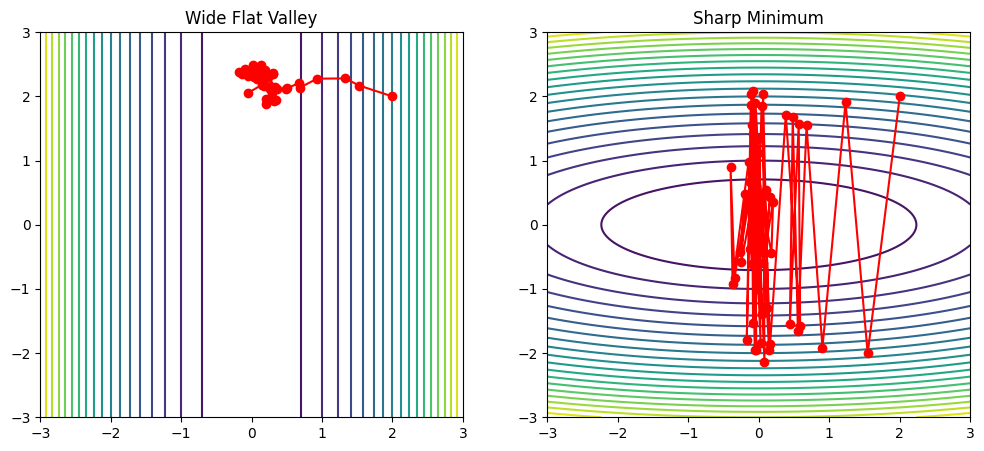

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ----- Define two losses -----
# Flat valley loss
def L_flat(w1, w2):
    return w1**2

# Sharp bowl loss
def L_sharp(w1, w2):
    return w1**2 + 10*w2**2

# ----- gradient descent -----
def sgd(loss_grad, w, lr=0.1, steps=50, noise=0.1):
    path = [w.copy()]
    for _ in range(steps):
        g = loss_grad(w)
        w = w - lr*g + noise*np.random.randn(*w.shape)
        path.append(w.copy())
    return np.array(path)

# gradients
grad_flat = lambda w: np.array([2*w[0], 0.0])
grad_sharp = lambda w: np.array([2*w[0], 20*w[1]])

# simulate
start = np.array([2.0, 2.0])
path_flat  = sgd(grad_flat,  start.copy(), lr=0.1)
path_sharp = sgd(grad_sharp, start.copy(), lr=0.1)

# ----- Plot -----
W = np.linspace(-3,3,200)
W1, W2 = np.meshgrid(W,W)
Z_flat  = L_flat(W1,W2)
Z_sharp = L_sharp(W1,W2)

fig, axes = plt.subplots(1,2,figsize=(12,5))

axes[0].contour(W1,W2,Z_flat,levels=20)
axes[0].plot(path_flat[:,0], path_flat[:,1], '-or')
axes[0].set_title("Wide Flat Valley")

axes[1].contour(W1,W2,Z_sharp,levels=20)
axes[1].plot(path_sharp[:,0], path_sharp[:,1], '-or')
axes[1].set_title("Sharp Minimum")

plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation

# ---------- Define toy losses ----------
def L_flat(w1, w2):
    # Flat in w2, quadratic in w1 -> manifold of minima along w2-axis
    return w1**2

def L_sharp(w1, w2):
    # Sharp in both dimensions
    return w1**2 + 10 * w2**2

# Grid
W = np.linspace(-2.5, 2.5, 200)
W1, W2 = np.meshgrid(W, W)
Z_flat  = L_flat(W1, W2)
Z_sharp = L_sharp(W1, W2)

# ---------- 3D static plots ----------
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1, projection="3d")
surf1 = ax1.plot_surface(W1, W2, Z_flat, cmap=cm.viridis, linewidth=0, antialiased=True)
ax1.set_title("Flat Valley: L(w1, w2) = w1^2")
ax1.set_xlabel("w1")
ax1.set_ylabel("w2")
ax1.set_zlabel("Loss")

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
surf2 = ax2.plot_surface(W1, W2, Z_sharp, cmap=cm.viridis, linewidth=0, antialiased=True)
ax2.set_title("Sharp Bowl: L(w1, w2) = w1^2 + 10 w2^2")
ax2.set_xlabel("w1")
ax2.set_ylabel("w2")
ax2.set_zlabel("Loss")

plt.tight_layout()
plt.show()

# ---------- Optional: rotating animation for one of them ----------
fig2 = plt.figure(figsize=(6,5))
ax = fig2.add_subplot(111, projection="3d")
surf = ax.plot_surface(W1, W2, Z_flat, cmap=cm.viridis, linewidth=0, antialiased=True)
ax.set_title("Rotating View: Flat Valley")

def update(frame):
    ax.view_init(elev=30, azim=frame)
    return (surf,)

anim = FuncAnimation(fig2, update, frames=np.linspace(0, 360, 120), interval=80, blit=True)

# In Colab, to display:
from IPython.display import HTML
HTML(anim.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

Epoch 10: train_loss=0.6511  val_loss=0.6435
Epoch 20: train_loss=0.5871  val_loss=0.5804
Epoch 30: train_loss=0.5153  val_loss=0.5107
Epoch 40: train_loss=0.4455  val_loss=0.4451
Epoch 50: train_loss=0.3867  val_loss=0.3915


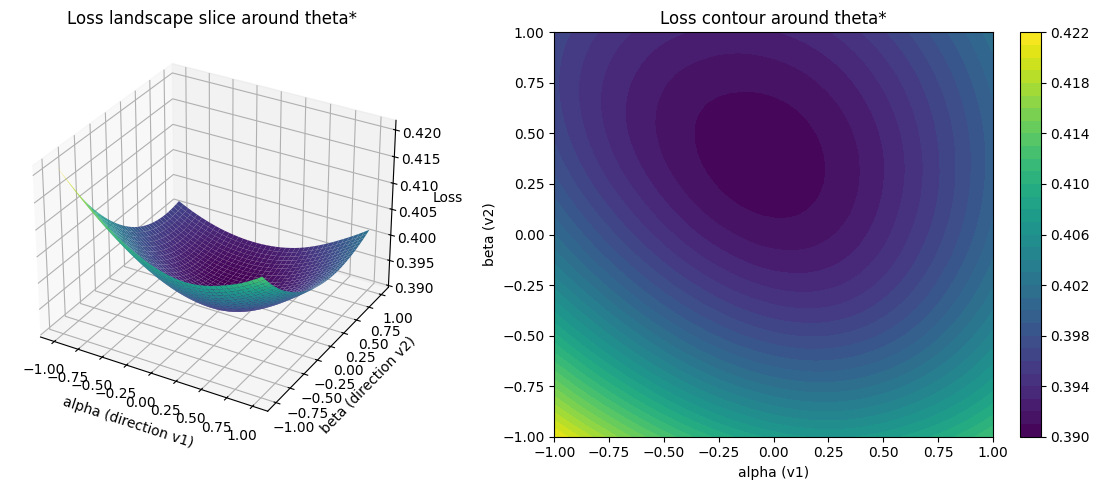

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

device = "cpu"

# ---------- 1. Toy dataset ----------
X, y = make_moons(n_samples=2000, noise=0.2, random_state=0)
X = torch.tensor(X, dtype=torch.float32, device=device)
y = torch.tensor(y, dtype=torch.long, device=device)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

# ---------- 2. Small MLP ----------
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )
    def forward(self, x):
        return self.net(x)

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# ---------- 3. Train a bit ----------
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    logits = model(X_train)
    loss = criterion(logits, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_loss = criterion(model(X_val), y_val).item()
        print(f"Epoch {epoch+1}: train_loss={loss.item():.4f}  val_loss={val_loss:.4f}")

# Flatten parameters to a single vector
def get_params_vector(model):
    return torch.cat([p.detach().flatten() for p in model.parameters()])

def set_params_vector(model, vec):
    idx = 0
    with torch.no_grad():
        for p in model.parameters():
            numel = p.numel()
            p.copy_(vec[idx:idx+numel].view_as(p))
            idx += numel

theta_star = get_params_vector(model)

# ---------- 4. Sample two random directions ----------
def random_direction_like(vec):
    d = torch.randn_like(vec)
    d /= d.norm() + 1e-8
    return d

v1 = random_direction_like(theta_star)
v2 = random_direction_like(theta_star)

# ---------- 5. Compute loss on a 2D grid around theta_star ----------
alphas = np.linspace(-1.0, 1.0, 41)
betas  = np.linspace(-1.0, 1.0, 41)
A, B = np.meshgrid(alphas, betas)
Z = np.zeros_like(A)

base_theta = theta_star.clone()

for i in range(len(alphas)):
    for j in range(len(betas)):
        a = A[j, i]
        b = B[j, i]
        new_theta = base_theta + a * v1 + b * v2
        set_params_vector(model, new_theta)
        with torch.no_grad():
            logits = model(X_val)
            loss_val = criterion(logits, y_val).item()
        Z[j, i] = loss_val

# Restore original params
set_params_vector(model, base_theta)

# ---------- 6. Plot surface and contours ----------
from mpl_toolkits.mplot3d import Axes3D  # noqa

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1, projection="3d")
ax1.plot_surface(A, B, Z, cmap="viridis", linewidth=0, antialiased=True)
ax1.set_xlabel("alpha (direction v1)")
ax1.set_ylabel("beta (direction v2)")
ax1.set_zlabel("Loss")
ax1.set_title("Loss landscape slice around theta*")

ax2 = fig.add_subplot(1,2,2)
cs = ax2.contourf(A, B, Z, levels=30, cmap="viridis")
fig.colorbar(cs, ax=ax2)
ax2.set_xlabel("alpha (v1)")
ax2.set_ylabel("beta (v2)")
ax2.set_title("Loss contour around theta*")

plt.tight_layout()
plt.show()

Smallest eigenvalues: [-7.65915525e-17  5.70039825e-04  2.38004851e-03  5.19112081e-03
  7.25053196e-03]


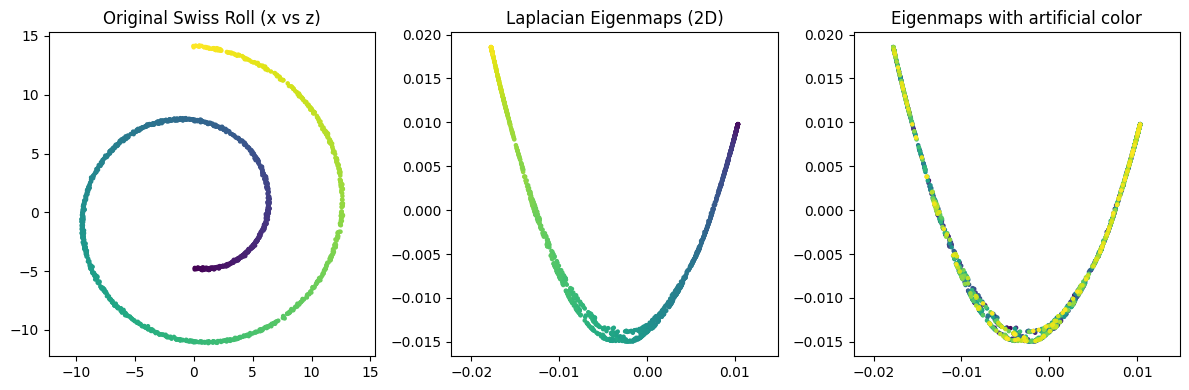

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph
from scipy.sparse import diags
from scipy.linalg import eigh

# 1) Make a Swiss roll
N = 1500
X_3d, t_param = make_swiss_roll(N, noise=0.05)   # X_3d: (N,3), t_param: manifold parameter
X = X_3d[:, [0, 2]]  # just keep x,z for plotting 2D projection

# 2) Build k-NN graph (k neighbors)
k = 10
knn_graph = kneighbors_graph(X_3d, k, mode="distance", include_self=False)
W = 0.5 * (knn_graph + knn_graph.T)  # symmetrize

# Convert distances to weights with Gaussian kernel
distances = W.data
sigma = np.mean(distances)
W.data = np.exp(-(distances**2) / (2 * sigma**2))

# Degree matrix (as vector)
d = np.array(W.sum(axis=1)).flatten()
D = diags(d)


# 3) Graph Laplacian (unnormalized)
L = csgraph.laplacian(W, normed=False)  # L = D - W

# Convert to dense for small N; for larger N, use sparse eigensolvers
L_dense = L.toarray()
D_dense = D.toarray()

# 4) Solve generalized eigenproblem L v = λ D v
eigvals, eigvecs = eigh(L_dense, D_dense)

# Skip the first eigenvector (λ ~ 0, constant)
LE_embed = eigvecs[:, 1:3]  # 2D embedding: columns 1 and 2

print("Smallest eigenvalues:", eigvals[:5])

# Plot Laplacian Eigenmaps embedding
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(X_3d[:,0], X_3d[:,2], c=t_param, s=5)
plt.title("Original Swiss Roll (x vs z)")
plt.axis("equal")

plt.subplot(1,3,2)
plt.scatter(LE_embed[:,0], LE_embed[:,1], c=t_param, s=5)
plt.title("Laplacian Eigenmaps (2D)")
plt.axis("equal")

plt.subplot(1,3,3)
plt.scatter(LE_embed[:,0], LE_embed[:,1], c=np.linspace(0,1,N), s=5)
plt.title("Eigenmaps with artificial color")
plt.axis("equal")

plt.tight_layout()
plt.show()

Top diffusion eigenvalues: [1.         0.99942996 0.99761995 0.99480888 0.99274947]


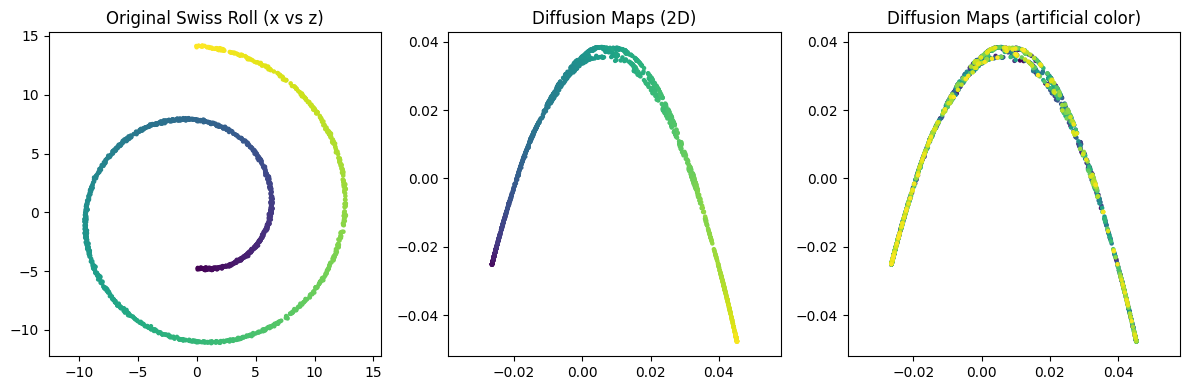

In [3]:
# 5) Diffusion Maps

# Row-stochastic Markov matrix P = D^{-1} W
d_inv = 1.0 / (d + 1e-12)
D_inv = diags(d_inv)
P = D_inv @ W   # (N,N) sparse

# Convert to dense for small N (N=1500 is okay)
P_dense = P.toarray()

# Eigen-decomposition: largest eigenvalues of P
# For Markov matrices, λ0=1 is the trivial stationary eigenvalue
eigvals_P, eigvecs_P = np.linalg.eig(P_dense)

# Sort by eigenvalue magnitude descending
order = np.argsort(-np.abs(eigvals_P))
eigvals_P = eigvals_P[order]
eigvecs_P = eigvecs_P[:, order]

print("Top diffusion eigenvalues:", eigvals_P[:5])

# Drop the trivial eigenvector at λ ~ 1 (constant)
DM_embed = np.real(eigvecs_P[:, 1:3])  # 2D diffusion embedding

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(X_3d[:,0], X_3d[:,2], c=t_param, s=5)
plt.title("Original Swiss Roll (x vs z)")
plt.axis("equal")

plt.subplot(1,3,2)
plt.scatter(DM_embed[:,0], DM_embed[:,1], c=t_param, s=5)
plt.title("Diffusion Maps (2D)")
plt.axis("equal")

plt.subplot(1,3,3)
plt.scatter(DM_embed[:,0], DM_embed[:,1], c=np.linspace(0,1,N), s=5)
plt.title("Diffusion Maps (artificial color)")
plt.axis("equal")

plt.tight_layout()
plt.show()

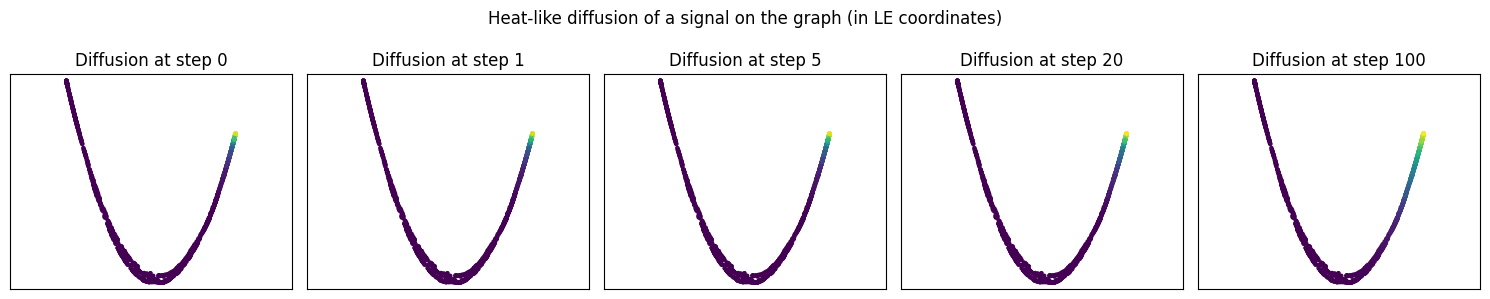

In [4]:
# 6) Graph diffusion: f_{t+1} = P f_t

# Initial signal: 1 on the "start" of the roll, 0 elsewhere
# Use t_param to localize the bump
f0 = np.exp(-((t_param - t_param.min())**2) / (2 * (1.0**2)))
f0 = f0 / f0.max()

f = f0.copy()

steps = [0, 1, 5, 20, 100]
max_step = max(steps)
F_snapshots = {}

for k in range(max_step+1):
    if k in steps:
        F_snapshots[k] = f.copy()
    f = P_dense @ f  # one diffusion step

plt.figure(figsize=(15,3))
for i, k in enumerate(steps):
    plt.subplot(1, len(steps), i+1)
    plt.scatter(LE_embed[:,0], LE_embed[:,1], c=F_snapshots[k], s=5)
    plt.title(f"Diffusion at step {k}")
    plt.axis("equal")
    plt.xticks([]); plt.yticks([])

plt.suptitle("Heat-like diffusion of a signal on the graph (in LE coordinates)")
plt.tight_layout()
plt.show()

Smallest eigenvalues: [1.42134481e-16 5.54439401e-04 2.46182609e-03 4.86849401e-03
 7.03552939e-03 8.84675418e-03]


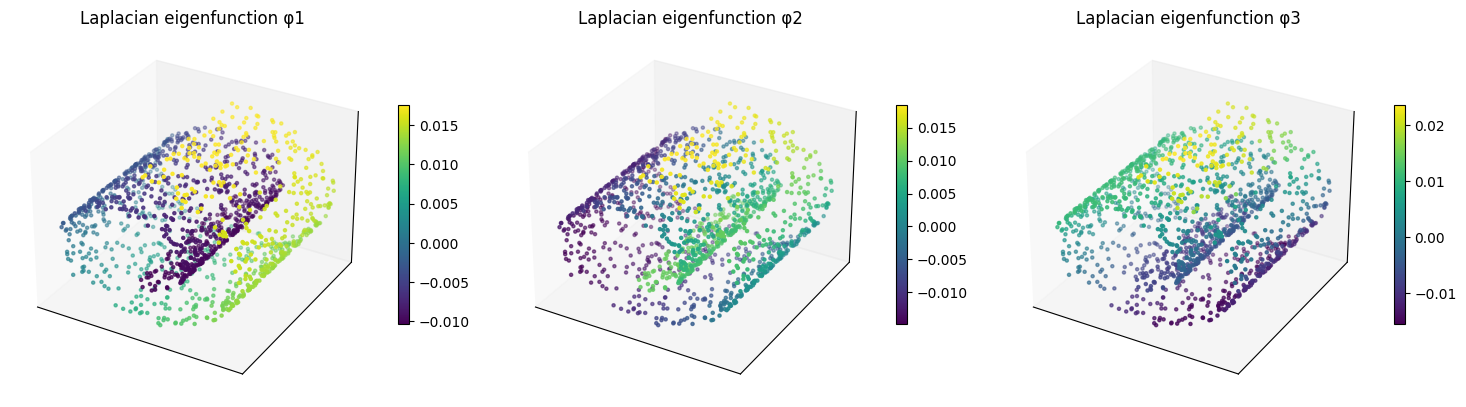

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph, diags
from scipy.linalg import eigh

# 1) Generate Swiss roll
N = 1500
X_3d, t_param = make_swiss_roll(N, noise=0.05)  # X_3d: (N,3), t_param: 1D "arc" parameter
# we'll also keep a simple 2D projection (x,z) just for visualization
X_proj = X_3d[:, [0, 2]]

# 2) Build k-NN graph in the full 3D space
k = 10
G = kneighbors_graph(X_3d, k, mode="distance", include_self=False)
W = 0.5 * (G + G.T)   # symmetrize distances

# 3) Turn distances into Gaussian similarity weights
distances = W.data
sigma = np.mean(distances)  # scale for kernel
W.data = np.exp(- (distances**2) / (2 * sigma**2))

# 4) Degree matrix
d = np.array(W.sum(axis=1)).flatten()
D = diags(d)


# 5) Unnormalized Laplacian
L = csgraph.laplacian(W, normed=False)  # L = D - W

# We’ll work with dense matrices (N=1500 is fine)
L_dense = L.toarray()
D_dense = D.toarray()

# 6) Solve L v = λ D v
eigvals, eigvecs = eigh(L_dense, D_dense)

print("Smallest eigenvalues:", eigvals[:6])

# First eigenvector (eigvals[0]) is ~constant; skip it.
# Take, say, eigenvectors 1,2,3 (the smoothest non-trivial modes)
phi1 = eigvecs[:, 1]
phi2 = eigvecs[:, 2]
phi3 = eigvecs[:, 3]


from mpl_toolkits.mplot3d import Axes3D  # needed for 3D proj

fig = plt.figure(figsize=(15,4))

for i, (phi, name) in enumerate([(phi1, "φ1"), (phi2, "φ2"), (phi3, "φ3")]):
    ax = fig.add_subplot(1, 3, i+1, projection="3d")
    p = ax.scatter(X_3d[:,0], X_3d[:,1], X_3d[:,2],
                   c=phi, cmap="viridis", s=5)
    fig.colorbar(p, ax=ax, shrink=0.6)
    ax.set_title(f"Laplacian eigenfunction {name}")
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

plt.tight_layout()
plt.show()

Correlation between φ1 and t_param: 0.9795550740246933


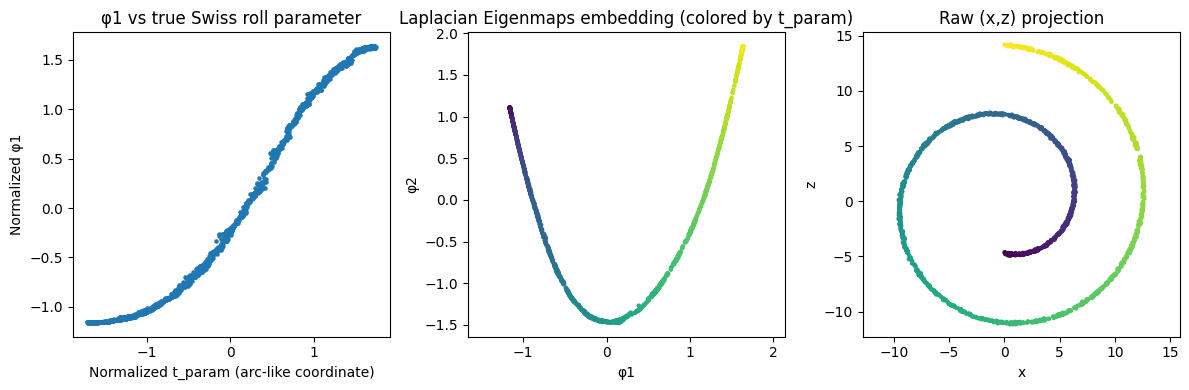

In [6]:
# Normalize for easy comparison: zero mean, unit variance
def normalize(v):
    v = v - v.mean()
    v = v / (v.std() + 1e-12)
    return v

phi1_n = normalize(phi1)
phi2_n = normalize(phi2)
t_n   = normalize(t_param)

# 1D comparison: Laplacian coordinate vs true Swiss roll parameter
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(t_n, phi1_n, s=5)
plt.xlabel("Normalized t_param (arc-like coordinate)")
plt.ylabel("Normalized φ1")
plt.title("φ1 vs true Swiss roll parameter")

# Correlation
corr = np.corrcoef(t_n, phi1_n)[0,1]
print("Correlation between φ1 and t_param:", corr)

# 2D Laplacian Eigenmaps embedding: (φ1, φ2)
plt.subplot(1,3,2)
plt.scatter(phi1_n, phi2_n, c=t_param, cmap="viridis", s=5)
plt.xlabel("φ1")
plt.ylabel("φ2")
plt.title("Laplacian Eigenmaps embedding (colored by t_param)")
plt.axis("equal")

# Compare with a simple (x,z) projection just to see distortion
plt.subplot(1,3,3)
plt.scatter(X_proj[:,0], X_proj[:,1], c=t_param, cmap="viridis", s=5)
plt.xlabel("x")
plt.ylabel("z")
plt.title("Raw (x,z) projection")
plt.axis("equal")

plt.tight_layout()
plt.show()

Smallest eigenvalues (L_sym): [1.17092402e-16 5.54439401e-04 2.46182609e-03 4.86849401e-03
 7.03552939e-03 8.84675418e-03]


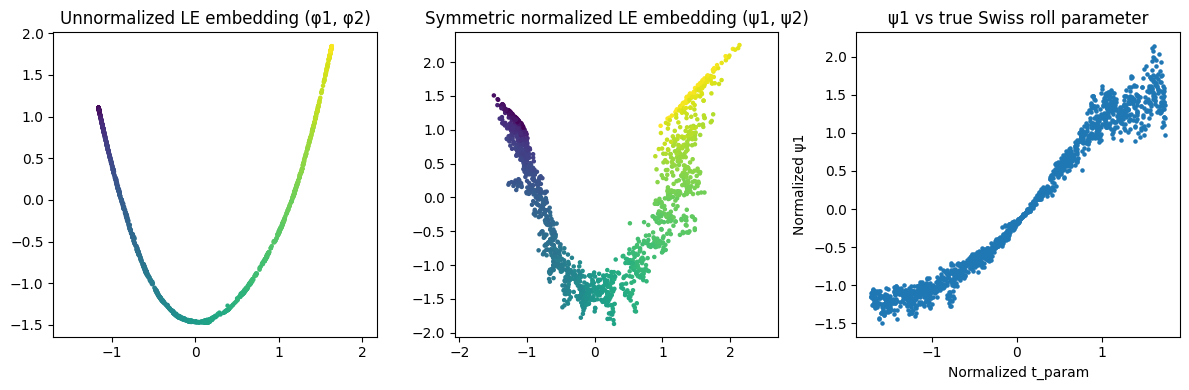

Correlation between ψ1 and t_param: 0.975047917737813


In [7]:
# --- Symmetric normalized Laplacian ---
L_sym = csgraph.laplacian(W, normed=True)  # L_sym = I - D^{-1/2} W D^{-1/2}
L_sym_dense = L_sym.toarray()

eigvals_sym, eigvecs_sym = np.linalg.eigh(L_sym_dense)
print("Smallest eigenvalues (L_sym):", eigvals_sym[:6])

# ignore the trivial eigenvector (constant-ish)
psi1 = eigvecs_sym[:, 1]
psi2 = eigvecs_sym[:, 2]

psi1_n = normalize(psi1)
psi2_n = normalize(psi2)

plt.figure(figsize=(12,4))

# Unnormalized (generalized) embedding (φ1, φ2)
plt.subplot(1,3,1)
plt.scatter(phi1_n, phi2_n, c=t_param, cmap="viridis", s=5)
plt.title("Unnormalized LE embedding (φ1, φ2)")
plt.axis("equal")

# Symmetric normalized embedding (ψ1, ψ2)
plt.subplot(1,3,2)
plt.scatter(psi1_n, psi2_n, c=t_param, cmap="viridis", s=5)
plt.title("Symmetric normalized LE embedding (ψ1, ψ2)")
plt.axis("equal")

# Compare 1D coordinate vs t_param for ψ1
plt.subplot(1,3,3)
plt.scatter(t_n, psi1_n, s=5)
plt.xlabel("Normalized t_param")
plt.ylabel("Normalized ψ1")
plt.title("ψ1 vs true Swiss roll parameter")
plt.tight_layout()
plt.show()

corr_psi1 = np.corrcoef(t_n, psi1_n)[0,1]
print("Correlation between ψ1 and t_param:", corr_psi1)

Top eigenvalues of P: [1.         0.99944556 0.99753817 0.99513151 0.99296447]


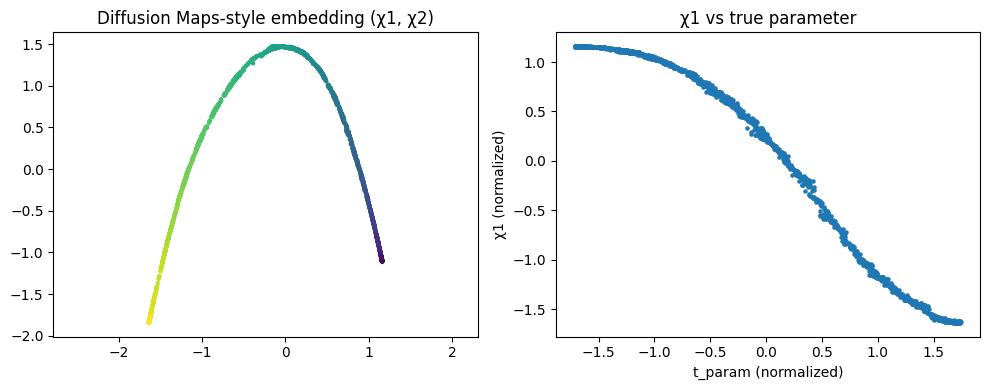

In [8]:
# Random-walk Markov operator: P = D^{-1} W
d_inv = 1.0 / (d + 1e-12)
D_inv = diags(d_inv)
P = D_inv @ W  # sparse
P_dense = P.toarray()

eigvals_P, eigvecs_P = np.linalg.eig(P_dense)
order = np.argsort(-np.abs(eigvals_P))
eigvals_P = eigvals_P[order]
eigvecs_P = eigvecs_P[:, order]

print("Top eigenvalues of P:", eigvals_P[:5])

# Skip trivial eigenvector (λ~1)
chi1 = np.real(eigvecs_P[:, 1])
chi2 = np.real(eigvecs_P[:, 2])
chi1_n = normalize(chi1)
chi2_n = normalize(chi2)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(chi1_n, chi2_n, c=t_param, cmap="viridis", s=5)
plt.title("Diffusion Maps-style embedding (χ1, χ2)")
plt.axis("equal")

plt.subplot(1,2,2)
plt.scatter(t_n, chi1_n, s=5)
plt.xlabel("t_param (normalized)")
plt.ylabel("χ1 (normalized)")
plt.title("χ1 vs true parameter")
plt.tight_layout()
plt.show()